# Preface

## about this document

Welcome to the main pipeline of minian!
The purpose of this annotated version of the minian pipeline is to guide the user through each step of the code, working with a short demo movie.
The intention is to enable the user to understand the code as much as possible so that they are equipped with the knowledge necessary to customize the code for their own needs, regardless of prior programming skills.

Before we start, it s highly recommended that you get familiar with basic python concepts and operations like [string manipulation](https://docs.python.org/3/library/string.html), [tuples, lists and dictionaries](https://docs.python.org/3/tutorial/datastructures.html).

The notes in this pipeline are supposed to give you minimal amount of knowledge to walkthrough the pipeline and touch on parameters that are most commonly tweaked.
The [Minian readthedocs](https://minian.readthedocs.io) site contains more comprehensive documentations.
In particular, the [API reference](https://minian.readthedocs.io/page/api/index.html) contains detailed documentation of every minian function.
Be sure to check them out whenever you are puzzled by how to specify parameters!

## text styling

Note on the styling of this document: most of the sentences should hopefully make sense if taken literally.
However, some special formatting of the text is used to demonstrate the close relationship between the concepts discussed and the code, as well as encouraging the reader to understand the Python syntax.
Specifically:

-  a [hyperlink](https://en.wikipedia.org/wiki/Hyperlink) usually points to a well-defined python module, class or methods, especially when that concept is first encountered in this document.
    The link usually points to the official documentation of that concept, which in some cases might not be the best place to start for a beginner.
    If you find the documentation puzzling, try to google the concept in question and find a tutorial that best suits you.
-  an inline `code` usually refers to a name that already exsists in the [namespace](https://docs.python.org/3/tutorial/classes.html#python-scopes-and-namespaces) (i.e. the context where we run the codes in this document).
    It can be a previously encountered concept, but more often it referes to variable names or method names that we [imported](https://docs.python.org/3/reference/import.html) or have defined along the way.
-  **bold** texts are used more loosely to highlight anything that requires more attention.
    Though they are not used as carefully as previous formats, they often refer to specific values that a variable or method arguments can assume.
-  <div class="alert alert-info">
    
    Info boxes are used to provide hints and tips to help users run through this pipeline smoothly.
    </div>

## workflow

There are 5 main sections in this pipeline: Setting up, Pre-processing, Motion Correction, Initialization, and CNMF, which are composed of interative spatial update and temporal update.

![workflow](img/workflow.png)

# Setting Up

The cells under this section should be executed every time the kernel is restarted.

## load modules

Loads the minian modules, usually this cell should not be modified.

In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
import itertools as itt
import os
import sys

import holoviews as hv
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
from holoviews.operation.datashader import datashade, regrid
from holoviews.util import Dynamic
from IPython.core.display import display

## set path and parameters

Set all of the parameters that control the notebook’s behavior.
Ideally, the following cell is the only part of the code the user will have to change when analyzing different datasets.
Here we briefly introduce only some of the initial parameters that are necessary to start the pipeline, and leave the discussion of specific parameters for later.

* `minian_path` is the path that contains the **minian** folder , where the minian codebase (.py files) reside.
    The default value `"."` means “current folder”, which should work in most cases, unless you want to try out another version of minian that is not in the same folder as this notebook.

* `dpath` is the folder that contains the videos to be processed.

* `interactive` controls whether interactive plots will be shown for parameters exploration.
    Interactive plotting requires CPU/memory usage, and thus could require some time (in particular, those steps where video is played).
    In principle, the user might want to visualize interactive plots during the initial parameters exploration, once the parameters are set and ready for batch processing, the user will set interactive as False to reduce processing time.

* `output_size` controls the relative size of all the plots on a scale of 0-100 percent, though it can be set to values >100 without any problem. 

* `param_save_minian` specifies the destination folder and format of the saved data.
    `dpath` is the folder path  where  the data will be saved.
    `meta_dict` is a `dictionary` that is used to construct meta data for the final labeled data structure.
    `overwrite` is a boolean value controlling whether the data is overwritten if a file already exists.
    We set it to `True` here so you can easily play with the demo multiple times, but **use caution** with this option during actual analysis.
    In addition to erasing prior data that may be important to you, overwritting data may cause compatibility issues with existing data from the same minian dataset folder.
    If you want to re-analyze a video from scratch using different parameters, it is recommended that you delete existing data first.

<div class="alert alert-info">
<strong>folder structure</strong>

The defult `meta_dict` in `param_save_minian` assumes output minian datasets are stored in heirarchiically arranged folders, as shown below:

```
mice1  
│
└───session1
│   │
│   └───minian
│       │   Y.zarr
│       │   A.zarr
│       │   ...
│   
└───session2
    │
    └───minian
```

The default value can be read as follows:
The name of the last folder (`-1`) in `dpath` (the folder that directly contains the videos) will be used to designate the value of a metadata dimension named `"session"`.
The name of the second-to-last folder (`-2`) in `dpath` will be used to designate the value for `"animal"` and so on.
Both the keys (name of metadata dimension) and values (numbers indicating which level of folder name should be used) of `meta_dict` can be modified to represent your preferred way of data storage. 
Note that the metadata are determined by the folder structure of saved minian datasets, not by those of input movie data.
</div>

In [2]:
# Set up Initial Basic Parameters#
minian_path = "."
dpath = "/Users/mbrosch/Library/CloudStorage/OneDrive-Personal/Aharoni_Lab/Experiments/WS_MS_imaging/July_2025/2025_07_25/WL3-ScopeB/Minian_demo_pipeline_data/scopeB/WL3"
minian_ds_path = os.path.join(dpath, "minian")
intpath = "./minian_intermediate"
subset = dict(frame=slice(0, 15000))
subset_mc = {'height': slice(59, 170), 'width': slice(58, 160)}
interactive = True
output_size = 100
#n_workers = int(os.getenv("MINIAN_NWORKERS", 2))
param_save_minian = {
    "dpath": minian_ds_path,
    "meta_dict": dict(session=-1, animal=-2),
    "overwrite": True,
}

# Pre-processing Parameters#
param_load_videos = {
    "pattern": ".*\.avi$",
    "dtype": np.uint8,
    "downsample": dict(frame=1, height=1, width=1),
    "downsample_strategy": "subset",
}
param_denoise = {"method": "median", "ksize": 5}
param_background_removal = {"method": "tophat", "wnd": 15}

# Motion Correction Parameters#
subset_mc = {'height': slice(59, 170), 'width': slice(58, 160)}
param_estimate_motion = {"dim": "frame"}

# Initialization Parameters#
param_seeds_init = {
    "wnd_size": 1000,
    "method": "rolling",
    "stp_size": 500,
    "max_wnd": 15,
    "diff_thres": 5,
}
param_pnr_refine = {"noise_freq": 0.03, "thres": 1.5}
param_ks_refine = {"sig": 0.01}
param_seeds_merge = {"thres_dist": 4, "thres_corr": 0.75, "noise_freq": 0.03}
param_initialize = {"thres_corr": 0.75, "wnd": 6, "noise_freq": 0.06}
param_init_merge = {"thres_corr": 0.8}

# CNMF Parameters#
param_get_noise = {"noise_range": (0.03, 0.5)}
param_first_spatial = {
    "dl_wnd": 8,
    "sparse_penal": 0.013,
    "size_thres": (30, 180),
}
param_first_temporal = {
    "noise_freq": 0.06,
    "sparse_penal": 1,
    "p": 1,
    "add_lag": 20,
    "jac_thres": 0.2,
}
param_first_merge = {"thres_corr": 0.8}
param_second_spatial = {
    "dl_wnd": 8,
    "sparse_penal": 0.015,
    "size_thres": (25, 140),
}
param_second_temporal = {
    "noise_freq": 0.06,
    "sparse_penal": 1,
    "p": 1,
    "add_lag": 20,
    "jac_thres": 0.4,
}

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MINIAN_INTERMEDIATE"] = intpath

## import minian

The following cell loads **minian** and usually should not be modified. If you encounter an `ImportError`, check that you followed the installation instructions and that `minian_path` is pointing to the right place.

In [3]:
%%capture
sys.path.append(minian_path)
from minian.cnmf import (
    compute_AtC,
    compute_trace,
    get_noise_fft,
    smooth_sig,
    unit_merge,
    update_spatial,
    update_temporal,
    update_background,
)
from minian.initialization import (
    gmm_refine,
    initA,
    initC,
    intensity_refine,
    ks_refine,
    pnr_refine,
    seeds_init,
    seeds_merge,
)
from minian.motion_correction import apply_transform, estimate_motion
from minian.preprocessing import denoise, remove_background
from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)
from minian.visualization import (
    CNMFViewer,
    VArrayViewer,
    generate_videos,
    visualize_gmm_fit,
    visualize_motion,
    visualize_preprocess,
    visualize_seeds,
    visualize_spatial_update,
    visualize_temporal_update,
    write_video,
)

## module initialization

The following cell handles initialization of modules and parameters necessary for minian to be run and usually should not be modified.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
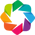

In [4]:
dpath = os.path.abspath(dpath)
hv.notebook_extension("bokeh", width=100)

## start cluster

In [5]:
import os
from dask.distributed import Client, LocalCluster
from minian.utilities import TaskAnnotation

# Close any existing client
try:
    Client.current().close()
except Exception:
    pass

# Use fewer, fatter workers on 32-GB RAM; leave ~6–8 GB for OS/browser
N_WORKERS = int(os.getenv("MINIAN_NWORKERS", 1))  # 1 is safest; 2 is okay if stable
THREADS_PER_WORKER = 4                            # good on M1/M2; can try 6
MEM_PER_WORKER = "20GB"                           # ~20 GB worker + headroom

cluster = LocalCluster(
    n_workers=N_WORKERS,
    threads_per_worker=THREADS_PER_WORKER,
    memory_limit=MEM_PER_WORKER,   # per worker
    resources={"MEM": 1},          # keep Minian’s resource hook
    processes=False,               # threads play nicer on macOS/ARM
    dashboard_address=":8787",
)

# Keep Minian’s annotation plugin
annt_plugin = TaskAnnotation()
cluster.scheduler.add_plugin(annt_plugin)

client = Client(cluster)
print(client)
print(f"Workers: {N_WORKERS} | Threads/worker: {THREADS_PER_WORKER} | Mem/worker: {MEM_PER_WORKER}")

<Client: 'inproc://10.104.17.222/20540/1' processes=1 threads=4, memory=20.00 GB>
Workers: 1 | Threads/worker: 4 | Mem/worker: 20GB


In [6]:
from dask.distributed import Client
c = Client.current()

# print last 2000 lines from workers + scheduler
for w, log in c.get_worker_logs().items():
    print(f"\n=== {w} ===\n{log[-2000:]}")

print("\n=== SCHEDULER ===")
for line in c.get_scheduler_logs()[-2000:]:
    print(line)


=== inproc://10.104.17.222/20540/3 ===
[('INFO', 'distributed.worker - INFO -       Start worker at: inproc://10.104.17.222/20540/3'), ('INFO', 'distributed.worker - INFO -          Listening to:        inproc10.104.17.222'), ('INFO', 'distributed.worker - INFO -          dashboard at:        10.104.17.222:49912'), ('INFO', 'distributed.worker - INFO - Waiting to connect to: inproc://10.104.17.222/20540/1'), ('INFO', 'distributed.worker - INFO - -------------------------------------------------'), ('INFO', 'distributed.worker - INFO -               Threads:                          4'), ('INFO', 'distributed.worker - INFO -                Memory:                   20.00 GB'), ('INFO', 'distributed.worker - INFO -       Local Directory: /Users/mbrosch/Documents/GitKraken_mac/minian/dask-worker-space/worker-h3j1zx25'), ('INFO', 'distributed.worker - INFO - -------------------------------------------------'), ('INFO', 'distributed.worker - INFO -         Registered to: inproc://10.104.17

# Pre-processing

In the pre-processing steps that follow, the pipeline will load and process the videos  (downsampling, subsetting, denoising).

All functions are evaluated lazily, which means that initially only a “plan” for the actual computation will be created, without its execution. Actual computations are carried out only when results are being saved

## loading videos and visualization

Recall the values of `param_load_videos`:

In [7]:
param_load_videos

{'pattern': '.*\\.avi$',
 'dtype': numpy.uint8,
 'downsample': {'frame': 1, 'height': 1, 'width': 1},
 'downsample_strategy': 'subset'}

The first argument of load_videos should be the path that contains the videos(`dpath`).
We then pass the dictionary, `param_load_videos`, defined earlier, which specifies several relevant arguments.
The argument `pattern` is optional and is the [regular expression](https://docs.python.org/3/library/re.html) used to filter files under the specified folder.
The default value `r"msCam[0-9]+\.avi$"` means that a file can only be loaded if its filename contains **'msCam'**, followed by at least one number, then **'.avi'** as the end of the filename.
This can be changed to suit the naming convention of your videos.
The resulting "video array" `varr` contains three dimensions: `height`, `width`, and `frame`.
If you wish to downsample the video, pass in a dictionary to `downsample`, with the name of dimensions as keys and  the downsampling folds as integer value.
For example, `downsample=dict("frame"=2)` will temporally downsample the video with a factor of 2.
`downsample_strategy` will assume two values: either `"subset"`, meaning downsampling are carried out simply by subsetting the data, or `"mean"`, meaning a mean will be calculated on the window of downsampling (the latter being slower).

In addition to the video array `varr`, the following cell also try to estimate best chunk size `chk` to use for computations.
This variable is needed for later steps since it's important to keep chunk size consistent within the pipeline.
If for some reason you have to restart the kernel at some point, remember to either note down the content of `chk` or rerun the following cell.

<div class="alert alert-info">
<strong>changing parameters</strong>

All minian parameters are `dict` and you can freely change them in various ways.
You can go back to the initial parameter setting cell and change things there.
Alternatively, you can add a code cell before running the relevant step.
For example, the following line will tell the function to load from `"/my/data_path"`:
```python
param_load_videos["vapth"] = "/my/data_path"
```
While the following line will change the downsample setting (which is specified as a `dict` on its own) when loading the video:
```python
param_load_videos["downsample"] = {"frame": 2}
```
</div>

In [ ]:
#varr = load_videos(dpath, **param_load_videos)
#chk, _ = get_optimal_chk(varr, dtype=float)

In [8]:
# Load the full video
varr = load_videos(dpath, **param_load_videos)

# Apply the subset BEFORE saving
varr = varr.isel(**subset)

# Recompute chunk size for the smaller dataset
chk, _ = get_optimal_chk(varr, dtype=float)


varr = save_minian(
    varr.chunk({"frame": chk["frame"], "height": -1, "width": -1}).rename("varr"),
    intpath,
    overwrite=True,
)

loading 1 videos in folder /Users/mbrosch/Library/CloudStorage/OneDrive-Personal/Aharoni_Lab/Experiments/WS_MS_imaging/July_2025/2025_07_25/WL3-ScopeB/Minian_demo_pipeline_data/scopeB/WL3


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with clang version 9.0.1
  configuration: --prefix=/Users/mbrosch/miniforge3/envs/minian-env --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, avi, from '/Users/mbrosch/Library/CloudStorage/OneDrive-Personal/Aharoni_Lab/Experiments/WS_MS_imaging/July_2025/2025_07_25/WL3-ScopeB/

We then immediately save the array representation to the intermediate folder to avoid repeatedly loading the video in later steps.

In [ ]:
#%%time
#varr = save_minian(
    #varr.chunk({"frame": chk["frame"], "height": -1, "width": -1}).rename("varr"),
    #intpath,
    #overwrite=True,
#)

The variable `varr` is a [xarray.DataArray](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html#xarray.DataArray).
Now is a perfect time to familiarize yourself with this data structure and the [xarray](https://xarray.pydata.org/en/stable/) module in general, since we will be using these data structures throughout the analysis.
Basically, a `xarray.DataArray` is N-dimensional array labeled with additional metadata, with many useful properties that make them easy to manipulate.
We can ask the computer to print out some information of `varr` by calling it (as with any other variable):

In [9]:
varr

<xarray.DataArray 'varr' (frame: 15000, height: 200, width: 200)>
dask.array<from-zarr, shape=(15000, 200, 200), dtype=uint8, chunksize=(750, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * frame    (frame) int64 0 1 2 3 4 5 6 ... 14994 14995 14996 14997 14998 14999
  * height   (height) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198 199
  * width    (width) int64 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199

We can see now that `varr` is a `xarray.DataArray` with a [name](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.name.html#xarray.DataArray.name) `"demo_movies"` and three dimensions: `frame`, `height` and `width`.
Each dimension is labeled with ascending natural numbers.
The [dtype](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.dtype.html#xarray.DataArray.dtype) ([data type](https://docs.scipy.org/doc/numpy-1.14.0/user/basics.types.html)) of `varr` is `numpy.uint8`.

## visualize raw data and optionally set roi for motion correction

Once the data is loaded we can visualize the content of `varr` with the help of `VArrayViewer`, which shows the array as a movie.
You can also plot summary traces like mean fluorescence across `frames` by passing a `list` of names of traces as inputs.
Currently `"mean"`, `"min"`, `"max"` and `"diff"` are supported, where `"diff"` is mean fluorescent value difference across all pixels in a frame.

`VArrayViewer` also supports a box drawing tool where you can draw a box in the field of view (FOV) and save it as a mask using the `“save mask”` button.
The mask is saved as `vaviewer.mask`, and can be retrieved and used at later stages, for example, when you want to run motion correction on a sub-region of the FOV.
See the [API reference](https://minian.readthedocs.io/page/api/minian.visualization.html#minian-visualization-VArrayViewer) for more detail.

In [10]:
import panel as pn
pn.extension()

hv.output(size=output_size)
if interactive:
    vaviewer = VArrayViewer(varr, framerate=5, summary=["mean", "max"])
    # Instead of inline display, launch in a new browser tab
    server = pn.serve(vaviewer.show(), show=True, port=0, start=True)
    # Keep 'server' around to stop later with server.stop()

computing summary


If you decide to set a mask for motion correction, the following cell is an example of how to convert the mask into a `subset_mc` parameter that can be later passed into motion correction functions.

In [ ]:
#if interactive:
    #try:
        #subset_mc = list(vaviewer.mask.values())[0]
    #except IndexError:
        #pass

In [ ]:
#subset_mc = {k: slice(int(v.start), int(v.stop)) for k, v in subset_mc.items()}
#print("Clean subset_mc:", subset_mc)

## subset part of video

Before proceeding to pre-processing, it’s good practice to check if there is anything obviously wrong with the video (e.g. the camera suddenly dropped, resulting in dark frames).
This can usually be observed by visualizing the video and plotting the timecourse of the mean fluorescence.
We can utilize the [xarray.DataArray.sel](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html) method and [slice](https://docs.python.org/3/library/functions.html#slice) to subset any part of the data we want.
By default `subset = None` will result in no subsetting.

<div class="alert alert-info">
<strong>subsetting data</strong>

The [xarray.DataArray.sel](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html) method takes in either a `dict` or keyword arguments.
In both cases you want to specify the dimension names and the coordinates of the subset as key-value pairs.
For example, say you want only the first 800 frames of the video, the following two lines will both work and they are equivalent:
```python
varr.sel(frame=slice(0, 799)) # slice object is inclusive on both ends
varr.sel({"frame": slice(0, 799)})
```
This also works on arbitrary dimensions.
For example, the following will give you a 100px x 100px chunk of your movie at a corner:
```python
varr.sel(height=slice(0, 99), width=slice(0, 99))
```
</div>

In [11]:
varr_ref = varr.sel(subset)

## glow removal and visualization

Here we remove the general glow background caused by vignetting effect.
We simply calculate a minimum projection across all `frame`s and subtract that projection from all `frame`s.
A benefit of doing this is you could interpret the result as "change of fluorescence from baseline", while preserving the linear scale of the raw data, which is usually the range of a 8-bit integer -- 0-255.
The result can be visualized again with `VArrayViewer`.

In [12]:
%%time
varr_min = varr_ref.min("frame").compute()
varr_ref = varr_ref - varr_min

CPU times: user 452 ms, sys: 179 ms, total: 631 ms
Wall time: 197 ms


In [ ]:
import panel as pn
pn.extension()

hv.output(size=int(output_size * 0.7))
if interactive:
    vaviewer = VArrayViewer(
        [varr.rename("original"), varr_ref.rename("glow_removed")],
        framerate=20,
        summary=None,
        layout=True,
    )
    # Open viewer in a new browser tab instead of inline
    server = pn.serve(vaviewer.show(), show=True, port=0, start=True)
    # Later: server.stop() to close

## denoise

Recall that by default we use a median filter for denoising:

In [13]:
param_denoise

{'method': 'median', 'ksize': 5}

There is only one parameter controlling how the filtering is done: the kernel size (`ksize`) of the filter.
The effect of this parameter can be visualized with the tool below.
Alternatively other methods like gaussian filter, anisotropic filter etc. are implmented as well.
See the [API reference](https://minian.readthedocs.io/page/api/minian.preprocessing.html#minian-preprocessing-denoise) for `denoise` for more detail.

<div class="alert alert-info">

Generally `ksize=5` is good (approximately half the diamater of the largest cell).
Note that if you do want to play with the ksize, it has to be odd number.
</div>

In [ ]:
import panel as pn
pn.extension()

hv.output(size=int(output_size * 0.6))
if interactive:
    app = visualize_preprocess(
        varr_ref.isel(frame=0).compute(),
        denoise,
        method=["median"],
        ksize=[3, 5, 7, 9],
    )
    # Serve in a new browser tab
    server = pn.serve(app, show=True, port=0, start=True)
    # When finished: server.stop()

The following cell would carry out denoise step.
Be sure to [change the parameters](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) based on visualization results before running the following cell.

In [14]:
varr_ref = denoise(varr_ref, **param_denoise)

## background removal

Recall the parameters for background removal:

In [15]:
param_background_removal

{'method': 'tophat', 'wnd': 15}

In [16]:
da = varr_ref.isel(frame=0)
print("dims:", da.dims, "shape:", da.shape)

dims: ('height', 'width') shape: (200, 200)


This step attempts to estimate background (everything except the fluorescent signal of in-focus cells) and subtracts it from the frame.
By default we use a morphological tophat operation to estimate the background from each frame:
First, a [disk element](http://scikit-image.org/docs/dev/api/skimage.morphology.html#disk) with a radius of `wnd` is created.
Then, a [morphological erosion](https://homepages.inf.ed.ac.uk/rbf/HIPR2/erode.htm) using the disk element is applied to each frame, which eats away any bright "features" that are smaller than the disk element.
Subsequently, a [morphological dilation](https://homepages.inf.ed.ac.uk/rbf/HIPR2/dilate.htm) is applied to the "eroded" image, which in theory undoes the erosion except the bright "features" that were completely eaten away.
The overall effect of this process is to remove any bright feature that is smaller than a disk with radius `wnd`.
Thus, when setting `wnd` to the **largest** expected radius of cell, this process can give us a good estimation of the background.
Then finally the estimated background is subtracted from each frame.

<div class="alert alert-info">

Pragmatically `wnd=15` works well.
</div>

In [ ]:
import dask, numpy as np, xarray as xr
import panel as pn
pn.extension()

hv.output(size=int(output_size * 0.6))

if interactive:
    # Pick one frame as (height, width) and compute it safely
    fr0 = (varr_ref.isel(frame=0).astype("float32"))
    with dask.config.set(scheduler="single-threaded"):
        img0 = np.asarray(fr0.compute(optimize_graph=False))  # (H, W) numpy

    # Wrap back into an xarray.DataArray with proper dims/coords
    fm = xr.DataArray(
        img0,
        dims=("height", "width"),
        coords={
            "height": varr_ref.coords["height"].values,
            "width":  varr_ref.coords["width"].values,
        },
        name="frame0",
    )

    # Build and serve the preprocessing viewer in a new tab
    app = visualize_preprocess(
        fm,
        remove_background,
        method=["tophat"],
        wnd=[10, 15, 20],
    )
    server = pn.serve(app, show=True, port=0, start=True)

The following cell would carry out background removal step.
Be sure to [change the parameters](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) based on visualization results before running the following cell.

In [17]:
varr_ref = remove_background(varr_ref, **param_background_removal)

## save result

Here we are saving our pre-processed video (`varr_ref`) into the intermediate folder (`intpath`).
Note that for every saved variable a separate folder will be created based on the `.name` attribute of that variable.
And variables with the same `.name` attribute will be saved to same folder regardless the variable name, potentially overwritting each other!
Here we [rename](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.rename.html) it to `"varr_ref"` so that the saved folder will be named "varr_ref.zarr".

In [18]:
%%time
varr_ref = save_minian(varr_ref.rename("varr_ref"), dpath=intpath, overwrite=True)

CPU times: user 18.6 s, sys: 297 ms, total: 18.9 s
Wall time: 4.95 s


# Motion Correction

## estimate motion

Recall the parameters for `estimate_motion`:

In [19]:
param_estimate_motion

{'dim': 'frame'}

By default the motion estimation process is simple: for each pair of frames it calculates a [phase correlation](https://en.wikipedia.org/wiki/Phase_correlation) between the two frames using [fft](https://en.wikipedia.org/wiki/Fast_Fourier_transform).
Then the peak of the phase correlation will correspond to the translational shift between the two frames.
The argument `dim` specifies along which dimension to run the motion estimation, and should always be set to `"frame"` here.
Usually this step is parameter-free, but see [API reference](https://minian.readthedocs.io/page/api/minian.motion_correction.html#minian-motion_correction-estimate_motion) for `estimate_motion` for more advanced tweaking of the parameters.
By default, the results from `estimate_motion` are saved in a two dimensional `DataArray` called `motion`, with two labels on the `shift_dim` dimension, representing the shifts along `"height"` and `"width"` directions.

In [20]:
%%time
motion = estimate_motion(varr_ref.sel(subset_mc), **param_estimate_motion)

CPU times: user 37.5 ms, sys: 1.54 ms, total: 39 ms
Wall time: 38.2 ms


## save motion

Here is the first time we save a variable to the final output folder using `param_save_minian`:

In [21]:
param_save_minian

{'dpath': '/Users/mbrosch/Library/CloudStorage/OneDrive-Personal/Aharoni_Lab/Experiments/WS_MS_imaging/July_2025/2025_07_25/WL3-ScopeB/Minian_demo_pipeline_data/scopeB/WL3/minian',
 'meta_dict': {'session': -1, 'animal': -2},
 'overwrite': True}

As mentioned before `param_save_minian` decides how your data will be saved and what metadata will be stored.
Additionally we use the `chk` variable earlier to make sure all our data have same chunk size along same dimension.

In [22]:
%%time
motion = save_minian(
    motion.rename("motion").chunk({"frame": chk["frame"]}), **param_save_minian
)

CPU times: user 4min 7s, sys: 7min 26s, total: 11min 33s
Wall time: 1min 21s


## visualization of motion

Here we visualize `motion` as a fluctuating curve across `frame`s.

In [23]:
hv.output(size=output_size)
visualize_motion(motion)

:NdOverlay   [Element]
   :Curve   [frame]   (motion)

## apply transform

After determining each frame's motion, we use the function `apply_transform` to correct for the motion.
Notably, we have to decide what to do with pixels that are shifted from outside of the FOV.
The default is to fill them with 0. 

In [24]:
Y = apply_transform(varr_ref, motion, fill=0)

## save result

Here we save two versions of the motion-corrected movie `Y`.
Their contents are identical.
The only difference is how they are chunked.
Also note that we convert the data to `float` type for better downstream processing.

In [25]:
%%time
Y_fm_chk = save_minian(Y.astype(float).rename("Y_fm_chk"), intpath, overwrite=True)
Y_hw_chk = save_minian(
    Y_fm_chk.rename("Y_hw_chk"),
    intpath,
    overwrite=True,
    chunks={"frame": -1, "height": chk["height"], "width": chk["width"]},
)

CPU times: user 33.8 s, sys: 5.23 s, total: 39 s
Wall time: 19.2 s


## visualization of motion-correction

Here we visualize the result of motion correction `Y_fm_chk` side by side with input `varr_ref`.

In [ ]:
import panel as pn
pn.extension()

hv.output(size=int(output_size * 0.7))
if interactive:
    vaviewer = VArrayViewer(
        [varr_ref.rename("before_mc"), Y_fm_chk.rename("after_mc")],
        framerate=5,
        summary=None,
        layout=True,
    )
    server = pn.serve(vaviewer.show(), show=True, port=0, start=True)
    # later: server.stop()

A potentially better visualization is to look at max projcetion across all frames before and after the motion correction.
You should see that the cells after motion correction have much more defined borders.

In [ ]:
im_opts = dict(
    frame_width=500,
    aspect=varr_ref.sizes["width"] / varr_ref.sizes["height"],
    cmap="Viridis",
    colorbar=True,
)
(
    regrid(
        hv.Image(
            varr_ref.max("frame").compute().astype(np.float32),
            ["width", "height"],
            label="before_mc",
        ).opts(**im_opts)
    )
    + regrid(
        hv.Image(
            Y_hw_chk.max("frame").compute().astype(np.float32),
            ["width", "height"],
            label="after_mc",
        ).opts(**im_opts)
    )
)

## generate video for motion-correction

Finally, we can generate a mp4 video for the original movie and motion-corrected movie side-by-side so that we can play it back at original speed.

In [26]:
%%time
vid_arr = xr.concat([varr_ref, Y_fm_chk], "width").chunk({"width": -1})
write_video(vid_arr, "minian_mc.mp4", dpath)

ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with clang version 9.0.1
  configuration: --prefix=/Users/mbrosch/miniforge3/envs/minian-env --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, rawvideo, from 'pipe:':
  Duration: N/A, start: 0.000000, bitrate: 16000 kb/s
    Stream #0:0: Video: rawvideo (Y800 / 0x30303859), gra

CPU times: user 18.7 s, sys: 1.01 s, total: 19.7 s
Wall time: 21.7 s


frame=18000 fps=2416 q=-1.0 Lsize=   64624kB time=00:09:59.96 bitrate= 882.4kbits/s dup=3000 drop=0 speed=80.5x    
video:64551kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.112005%
[libx264 @ 0x7fd697809400] frame I:72    Avg QP:14.01  size:  9127
[libx264 @ 0x7fd697809400] frame P:17928 Avg QP:16.87  size:  3650
[libx264 @ 0x7fd697809400] mb I  I16..4: 100.0%  0.0%  0.0%
[libx264 @ 0x7fd697809400] mb P  I16..4: 13.0%  0.0%  0.0%  P16..4: 82.9%  0.0%  0.0%  0.0%  0.0%    skip: 4.1%
[libx264 @ 0x7fd697809400] coded y,uvDC,uvAC intra: 91.9% 0.0% 0.0% inter: 72.1% 0.0% 0.0%
[libx264 @ 0x7fd697809400] i16 v,h,dc,p: 19% 33% 43%  6%
[libx264 @ 0x7fd697809400] i8c dc,h,v,p: 100%  0%  0%  0%
[libx264 @ 0x7fd697809400] kb/s:881.33


'/Users/mbrosch/Library/CloudStorage/OneDrive-Personal/Aharoni_Lab/Experiments/WS_MS_imaging/July_2025/2025_07_25/WL3-ScopeB/Minian_demo_pipeline_data/scopeB/WL3/minian_mc.mp4'

# Initialization

In order to run CNMF, we first need to generate an initial estimate of where our cells are likely to be and what their temporal activity is likely to look like.
The whole initialization section is adapted from the [MIN1PIPE](https://github.com/JinghaoLu/MIN1PIPE) package.
See the [paper](https://www.cell.com/cell-reports/fulltext/S2211-1247(18)30826-X) for full details about the theory.

## compute max projection

Here we calculate a max projection that will be used later.
We also save this max projection in the output data folder, since it will be useful when carrying out cross-session registrations.

In [27]:
max_proj = save_minian(
    Y_fm_chk.max("frame").rename("max_proj"), **param_save_minian
).compute()

subset_mc_needs to be changed from inital raw video masking

In [ ]:
subset_mc = {'height': slice(45, 170), 'width': slice(58, 160)}


## generating over-complete set of seeds

In [ ]:
print(subset_mc)

In [ ]:
#insert by Marcel, used the cropped version of the video to FOV with the maske created further up
varr_seed = Y_fm_chk.sel(**subset_mc) if subset_mc else Y_fm_chk   # Y_fm_chk = motion-corrected movie


We first generate an over-complete set of **seeds**.
Recall the parameters:

In [ ]:
param_seeds_init

The idea is that we select some subset of frames, compute a max projection of those frames, and find the local maxima of that max projection.
We keep repeating this process and we collect all the local maxima until we obtain an overly-complete set of local maximas, which are the potential locations of cells, which we call **seeds**.
The assumption here is that the center of cells are brighter than their surroundings on some, but not necessarily all, frames.
There are several parameters controlling how we subset the frames:
By default we use `method="rolling"`, which use a rolling window across time to chunk and compute max projections.
`wnd_size` controls the number of frames in each chunk.
`stp_size` is the distance between the center of each chunk.
For example, if `wnd_size=100` and `stp_size=50`, the windows will be as follows: (0, 100), (50, 150), (100, 200)...
Alternatively you can use `method="random"` to use random sampling of frames instead of rolling window.
See the [API reference](https://minian.readthedocs.io/page/api/minian.initialization.html#minian-initialization-seeds_init) of `seeds_init` for details.
Additionally we have two parameters controlling how the local maxima are found.
`max_wnd` controls the window size within which a single pixel will be choosen as local maxima.
In order to capture cells with all sizes, we actually find local maximas with different window size and merge all of them, starting from 2 all the way up to `max_wnd`.
Hence `max_wnd` should be the radius of the **largest** cell you want to detect.
Finally in order to get rid of local maxima with very little fluctuation, we set a `diff_thres` which is the minimal fluorescent diffrence of a seed across `frame`s.
Since the linear scale of the raw data is preserved, we can set this threshold empirically.

In [ ]:
%%time
seeds = seeds_init(varr_seed, **param_seeds_init) #was Y_fm_chk

The `seeds` variable is a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), with each row representing a seed.
The column "height" and "width" defines the location of the seed.
The column "seeds" is the number of chunks where the particular seed/pixel is considered a local maxima.

In [ ]:
seeds.head()

We can visualize the seeds as points overlaid on top of the `max_proj` image. Each white dot is a seed and could potentially be the location of a cell. 

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds)

In [ ]:
# Reuse max_proj
mp = max_proj.astype("float32")

# Apply robust clipping
lo, hi = np.percentile(mp.values, [1, 99.5])
mp_robust = mp.clip(lo, hi)

# Make display bigger
hv.output(size=150)  # increase size (default is ~100)

# Base image
img = hv.Image(mp_robust, kdims=['width','height']).opts(
    clim=(lo, hi), 
    cmap="inferno", 
    frame_width=500, frame_height=500  # control size
)

# Overlay with seeds
overlay = img * visualize_seeds(mp_robust, seeds)

overlay

## peak-noise-ratio refine

Next, we refine seeds based upon their temporal activity.
This requires that we separate our signal from noise based upon frequency.
To find the best cut-off frequency, we are going to take a few example seeds and separate their activity with different cut-off frequencies.
We will then view the results and select a frequency which we believe best separates signal from noise.

This is a complicated part in the pipeline, but it is important to understand since the idea is used later and it will allow you to do parameter exploration based on your need.
The basic idea is to run some function on a small subset of the data using different parameters within a for loop, and then visualizing the results using `holoviews`.

We will go line by line:

1. First we create a `list` of frequencies we want to test -- `noise_freq_list`.
    The "frequency" values here are a fraction of your **sampling rate**.
    Note that if you have temporally downsampled, the fraction here is relative to the downsampled rate.
1. Then we randomly select 6 rows from `seeds` and call them `example_seeds`.
1. Then we pull out the corresponding temporal activities of the 6 selected seeds and assign it to `example_trace`.
1. We then create an empty dictionary `smooth_dict` to store the resulting visualizations.
1. After initializing these variables, we use a `for` loop to iterate through `noise_freq_list`, with one of the values from the list as `freq` during each iteration.
1. Within the loop, we run `smooth_sig` twice on `example_trace` with the current `freq` we are testing out.
    The low-passed result is assigned to `trace_smth_low`, while the high-pass result is assigned to `trace_smth_high`.
1. Then we make sure to actually carry-out the computation by calling the `compute` method on the resulting `DataArray`s.
1. Next, we turn the two traces into visualizations:
    we construct interactive line plots ([hv.Curve](http://holoviews.org/reference/elements/bokeh/Curve.html)s) from them and put them in a container called a [hv.HoloMap](http://holoviews.org/reference/containers/bokeh/HoloMap.html).
1. Finally, we store the whole visualization in `smooth_dict`, with the keys being the `freq` and values corresponding to the result of this iteration.

<div class="alert alert-info">

So if you want to customize the parameter values to explore, in this case the cut-off frequency to test, you can edit `noise_freq_list`.
</div>

In [ ]:
%%time
if interactive:
    noise_freq_list = [0.005, 0.01, 0.02,0.03,0.04,0.05, 0.06,0.07,0.08, 0.1, 0.2, 0.3, 0.45, 0.6, 0.8]
    example_seeds = seeds.sample(6, axis="rows")
    example_trace = Y_hw_chk.sel(
        height=example_seeds["height"].to_xarray(),
        width=example_seeds["width"].to_xarray(),
    ).rename(**{"index": "seed"})
    smooth_dict = dict()
    for freq in noise_freq_list:
        trace_smth_low = smooth_sig(example_trace, freq)
        trace_smth_high = smooth_sig(example_trace, freq, btype="high")
        trace_smth_low = trace_smth_low.compute()
        trace_smth_high = trace_smth_high.compute()
        hv_trace = hv.HoloMap(
            {
                "signal": (
                    hv.Dataset(trace_smth_low)
                    .to(hv.Curve, kdims=["frame"])
                    .opts(frame_width=300, aspect=2, ylabel="Signal (A.U.)")
                ),
                "noise": (
                    hv.Dataset(trace_smth_high)
                    .to(hv.Curve, kdims=["frame"])
                    .opts(frame_width=300, aspect=2, ylabel="Signal (A.U.)")
                ),
            },
            kdims="trace",
        ).collate()
        smooth_dict[freq] = hv_trace

At the end of the process, we put together a `smooth_dict`.
Here we convert that into an interactive plot, from which we can determine the frequency that best separates noise and signal.

In [ ]:
hv.output(size=int(output_size * 0.7))
if interactive:
    hv_res = (
        hv.HoloMap(smooth_dict, kdims=["noise_freq"])
        .collate()
        .opts(aspect=2)
        .overlay("trace")
        .layout("seed")
        .cols(3)
    )
    display(hv_res)

In [ ]:
import holoviews as hv
import panel as pn
pn.extension()

# Make each subplot big and readable
hv.opts.defaults(
    hv.opts.Curve(frame_width=900, frame_height=300),  # size of each trace
)

hv_res_big = (
    hv.HoloMap(smooth_dict, kdims=["noise_freq"])  # keeps the slider
      .collate()
      .overlay("trace")        # overlay signal & noise
      .layout("seed")          # one panel per seed
      .cols(2)                 # 2 columns -> larger panels
)

# Open in a new browser tab, keep slider, give the page room to breathe
pn.serve(
    pn.panel(hv_res_big, sizing_mode="stretch_width"),
    show=True, port=0, title="PNR refine",
)

<div class="alert alert-info">
<strong>picking noise frequency</strong>

We can now use the interactive visualization to pick the best cut-off frequency.
Here is an example of what you might see:

<div stype="clear:both"><img src="img/param_pnr.png" style="width: 50%"/></div>

We are looking for the frequency that can best seperate real signal from noise.
Hence, `noise_freq=0.005` in the example is not ideal, since real calcium activities are overly smoothed as well.
At the same time, `noise_freq=0.45` is not ideal either, since a lot of high-frequency noise are visible in the signal.
Hence, `noise_freq=0.05` in the middle is a good choice in this example.
Now, say you already found your parameters, it's time now to pass them in! Either go back to initial parameters setting step and modify them there, or call the parameter here and change its value/s accordingly.
</div>

Having determined the frequency that best separates signal from noise, we move on to peak-noise-ratio refining.
Recall the parameters:

In [ ]:
param_pnr_refine

First we filter the temporal activities for each seed using the `noise_freq` we choose.
**signal** is defined as the low-pass filtered temporal signal, while **noise** is high-pass filtered signal.
Then we compute the peak-to-peak value (max minus min) for both the **real** signal and **noise** signal.
The peak-noise-ratio is defined as the ratio between the peak-to-peak value of **signal** and that of **noise**.
We then threshold the seeds based on this peak-noise-ratio, with the assumption that temporal activities from real cells should have higher fluctuation in the low-frequency range and lower fluctuation in the high-frequency range.
`thres` is the threshold for peak-noise-ratios.
Pragmatically `thres=1` works fine and makes sense.
You can also use `thres="auto"`, where a gaussian mixture model with 2 components will be run on the peak-noise-ratios and seeds will be selected if they belong to the "higher" gaussian.

The following cell would carry out pnr refinement step.
Be sure to [change](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) the `noise_freq` based on visualization results before running the following cell.

In [ ]:
%%time
seeds, pnr, gmm = pnr_refine(Y_hw_chk, seeds, **param_pnr_refine)

The resulting `seeds` dataframe will have an additional column "mask_pnr" showing you whether a seed passed the peak-noise-ratio threshold.

In [ ]:
seeds.head()

If you chose `thres="auto"` you can use the following cell to visualize the gaussian mixture model fit.

In [ ]:
if gmm:
    display(visualize_gmm_fit(pnr, gmm, 100))
else:
    print("nothing to show")

We can visualize seeds on top of the max projection again.
This time we can also pass in "mask_pnr" so that the visualization can show us which seeds are filtered out in `pnr_refine`.
White dots are accepted seeds and red dots are taken out.

<div class="alert alert-info">

If you see seeds being filtered out that you believe should be cells, either skip this step or try lower the threshold a bit.
</div>

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds, "mask_pnr")

In [ ]:
#look at PNR distribution
import numpy as np
import holoviews as hv
hv.extension('bokeh')

pnr_vals = pnr.values

hist = hv.Histogram(np.histogram(pnr_vals, bins=60)).opts(
    frame_width=600, frame_height=400,
    xlabel='PNR', ylabel='count',
    xticks=30
)

thres_line = hv.VLine(1).opts(color='red', line_width=2)

(hist * thres_line)

In [ ]:
# Reuse max_proj
mp = max_proj.astype("float32")

# Apply robust clipping
lo, hi = np.percentile(mp.values, [1, 99.5])
mp_robust = mp.clip(lo, hi)

# Make display bigger
hv.output(size=150)  # increase size (default is ~100)

# Base image
img = hv.Image(mp_robust, kdims=['width','height']).opts(
    clim=(lo, hi), 
    cmap="inferno", 
    frame_width=500, frame_height=500  # control size
)

# Overlay with seeds
overlay = img * visualize_seeds(mp_robust, seeds,"mask_pnr")

overlay

## ks refine

`ks_refine` refines the seeds using [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test).
Recall the parameters:

In [ ]:
param_ks_refine

The idea is simple: if a seed corresponds to a cell, its fluorescence intensity across frames should be distributed following a [bimodal](https://en.wikipedia.org/wiki/Multimodal_distribution) distribution, with a large peak representing noise/little activity, and another peak representing when the seed/cell is active.
Thus, we can carry out KS test on the distribution of fluorescence intensity of each seed, and keep only the seeds where the null hypothesis (that the fluorescence is just a normal distribution) is rejected.
`sig` is the p value at which the null hypothesis is rejected. 

In [ ]:
%%time
seeds = ks_refine(Y_hw_chk, seeds, **param_ks_refine)

We can visualize seeds on top of the max projection.
White dots are accepted seeds and red dots are taken out.

<div class="alert alert-info">

The ks refine step tend to have minimal impact.
It's quite normal to see no seeds being filtered out and you can proceed in such cases.
</div>

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds, "mask_ks")

At this point, much of our refined seeds likely reflect the position of an actual cell.
However, we are likely to still have multiple seeds per cell, which we want to avoid.
Here we discard redundant seeds through a process of merging.
Recall the parameters:

In [ ]:
param_seeds_merge

The function `seeds_merge` attempts to merge seeds together which potentially come from the same cell, based upon their spatial distance and temporal correlation.
Specifically, `thres_dist` is the threshold for euclidean distance between pairs of seeds, in pixels, and `thres_corr` is the threshold for pearson correlation between pairs of seeds.
In addition, it's very beneficial to smooth the signals before computing the correlation, and `noise_freq` determines how smoothing should be done.
Any pair of seeds that are within `thres_dist` **and** has a correlation higher than `thres_corr` will be merged together, such that only the seed with maximum intensity in the max projection of the video will be kept.

Note that we apply the masking from previous refining steps here and use only those seeds as input to `seeds_merge`.

<div class="alert alert-info">

Since the merge is carried out transitively, in practice it is beneficial to keep `thres_dist` small to avoid over-merging, especially when the density of cells is high.
The goal of this step is to reduce the number of duplicated seeds as much as possible, but not over-merge the seeds, since merging is irreversible.
Hence it is OK to have multiple seeds per cell at this stage.
</div>

In [ ]:
%%time
seeds_final = seeds[seeds["mask_ks"] & seeds["mask_pnr"]].reset_index(drop=True)
seeds_final = seeds_merge(Y_hw_chk, max_proj, seeds_final, **param_seeds_merge)

We visualize the result on top of the max projection.
The red dots here indicate seeds that has been merged to nearby seeds (those shown in white).

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds_final, "mask_mrg")

In [ ]:
# Reuse max_proj
mp = max_proj.astype("float32")

# Apply robust clipping
lo, hi = np.percentile(mp.values, [1, 99.5])
mp_robust = mp.clip(lo, hi)

# Make display bigger
hv.output(size=150)  # increase size (default is ~100)

# Base image
img = hv.Image(mp_robust, kdims=['width','height']).opts(
    clim=(lo, hi), 
    cmap="inferno", 
    frame_width=500, frame_height=500  # control size
)

# Overlay with seeds
overlay = img * visualize_seeds(mp_robust, seeds_final,"mask_mrg")

overlay

## initialize spatial matrix

Up till now, the seeds we have are only one-pixel dots.
In order to kick start CNMF we need something more like the spatial footprint (`A`) and temporal activities (`C`) of real cells.
Thus we need to `initilalize` `A` and `C` from the seeds we have.
Recall the parameters:

In [ ]:
param_initialize

To obtain the initial spatial matrix `A`, for each seed, we calculate Pearson correlation between the seed and surrounding pixels.
Calculating correlation with all other pixels for every seed is time-consuming and unnecessary.
Hence we use `wnd` to control the window size for calculating the correlation, and thus is the maximum possible size of any spatial footprint in the initial spatial matrix.
At the same time we do not want pixels with low correlation value to influence our estimation of temporal signals, thus a `thres_corr` is also implemented where only pixels with correlation above this threshold are kept.

%%time
A_init = initA(Y_hw_chk, seeds_final[seeds_final["mask_mrg"]], **param_initialize)
A_init = save_minian(A_init.rename("A_init"), intpath, overwrite=True)

In [ ]:
%%time
A_init = initA(Y_hw_chk, seeds_final[seeds_final["mask_mrg"]], **param_initialize)
A_init = save_minian(A_init.rename("A_init"), intpath, overwrite=True)

In [ ]:
import numpy as np, holoviews as hv
hv.extension('bokeh')

unit_dim = "unit" if "unit" in A_init.dims else "unit_id"

# pick top N units once
N = 500
nz = (A_init > 0).sum(dim=("height","width")).values
idx = np.argsort(-nz)[:N]

# centroids
ys, xs = [], []
for i in idx:
    m = (A_init.isel({unit_dim:int(i)}) > 0)
    if m.any():
        yy, xx = np.where(m)
        ys.append(yy.mean())
        xs.append(xx.mean())

# plot
overlay = hv.Image(mp.rename("max_proj"), kdims=["width","height"]).opts(
    cmap="gray", clim=(lo,hi), width=600, height=600
)

pts = hv.Points(np.c_[xs, ys], kdims=['width','height']).opts(
    size=8, color='red', marker='x', line_width=2
)

overlay * pts

## initialize temporal matrix

After generating `A`, for each seed, we calculate a weighted average of pixels around the seed, where the weight are the initial spatial footprints in `A` we just generated.
We use this weighted average as the initial estimation of temporal activities for each units in `C`.

In [ ]:
%%time
C_init = initC(Y_fm_chk, A_init)
C_init = save_minian(
    C_init.rename("C_init"), intpath, overwrite=True, chunks={"unit_id": 1, "frame": -1}
)

## merge units

We want to do another pass of merging before proceeding, and this time we want to merge based on initialized `A` and `C`.
Recall the parameters:

In [ ]:
param_init_merge

The `unit_merge` consider all cells whose spatial footprints have at least one pixel in common to be potential target of merging.
Hence, the only parameter you need to specify is a threshold for the correlation of the temporal activities of cells to be merged.

In [ ]:
%%time
A, C = unit_merge(A_init, C_init, **param_init_merge)
A = save_minian(A.rename("A"), intpath, overwrite=True)
C = save_minian(C.rename("C"), intpath, overwrite=True)
C_chk = save_minian(
    C.rename("C_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)

## initialize background terms

Finally, we need two more terms: `b` and `f`, representing the spatial footprint and temporal dynamics of the background, respectively.
We first compute an estimation of cellular activities by taking the outer product of `A` and `C`, resulting in an video array with dimesion `height`, `width` and `frame`.
We then subtract this array from `Y_fm_chk`, resulting in a "residule" movie.
Then `b` is estimated as the mean projection of the "residule" movie, while `f` is estimated as the fluorescence fluctuation of `b` that best fit the "residule" movie (least-square solution).

In [ ]:
%%time
b, f = update_background(Y_fm_chk, A, C_chk)
f = save_minian(f.rename("f"), intpath, overwrite=True)
b = save_minian(b.rename("b"), intpath, overwrite=True)

## visualization of initialization

Finally we visualize the result of our initialization by plotting a projection of the spatial matrix `A`, a raster of the temporal matrix `C`, as well as background terms `b` and `f`.

In [ ]:
hv.output(size=int(output_size * 0.55))
im_opts = dict(
    frame_width=500,
    aspect=A.sizes["width"] / A.sizes["height"],
    cmap="Viridis",
    colorbar=True,
)
cr_opts = dict(frame_width=750, aspect=1.5 * A.sizes["width"] / A.sizes["height"])
(
    regrid(
        hv.Image(
            A.max("unit_id").rename("A").compute().astype(np.float32),
            kdims=["width", "height"],
        ).opts(**im_opts)
    ).relabel("Initial Spatial Footprints")
    + regrid(
        hv.Image(
            C.rename("C").compute().astype(np.float32), kdims=["frame", "unit_id"]
        ).opts(cmap="viridis", colorbar=True, **cr_opts)
    ).relabel("Initial Temporal Components")
    + regrid(
        hv.Image(
            b.rename("b").compute().astype(np.float32), kdims=["width", "height"]
        ).opts(**im_opts)
    ).relabel("Initial Background Sptial")
    + datashade(hv.Curve(f.rename("f").compute(), kdims=["frame"]), min_alpha=200)
    .opts(**cr_opts)
    .relabel("Initial Background Temporal")
).cols(2)

# CNMF

This section assumes you already have some background knowledge about the CNMF algorithm.
Please refer to the [the paper](https://www.sciencedirect.com/science/article/pii/S0896627315010843) for detailed information of the algorithm. 

As a quick recap, here is the essential idea of CNMF:
We believe our movie, `Y`, with dimensions `height`, `width` and `frame`, can be written in (and thus broken down as) the following equation:

$$\mathbf{Y} = \mathbf{A}^T \mathbf{C} + \mathbf{b}^T \mathbf{f} + \epsilon$$

where:

* `A` is the spatial footprint of each unit, with dimension `height`, `width` and `unit_id`.
* `C` is the temporal activities of each unit, with dimension `unit_id` and `frame`.
* `b` and `f` are the spatial footprint and temporal activities of some background, respectively.
* $\epsilon$ is the noise.

Note that strictly speaking, matrix multiplication is usually only defined for two dimensional matrices, but our `A` here has three dimensions, so in fact we are taking the [tensor product](https://en.wikipedia.org/wiki/Tensor_product) of `A` and `C`, reducing the dimension `unit_id`.
This might seem to complicate things (compared to just treating `height` and `width` as one flattened `spatial` dimension), but it ends up making some sense.
When you take a dot product of any two "matrices" on a certain **dimension**, all that is happening is a **product** followed by a **sum** -- you take the product for all pairs of numbers with the the same indexes from the two "matrices", and then you take the sum of all those products along the dimension.
Thus when we take the tensor product of `A` and `C`, we are actually multiplying all those numbers in dimension `height`, `width` and `frame`, matched by `unit_id`, and then take the sum.
Conceptually, for each unit, we are weighting the spatial footprint (`height` and `width`) by the fluorecense of that unit on given `frame`, which is the **product**, and then we are collapsing all units together, which is the **sum**.
With that, the equation above is trying to say that our movie is made up of a weighted sum of the spatial footprint and temporal activities of all units, plus some background and noise.

Now, there is another rule about `C` that separates it from background and noise:
Each "row" of `C`, which is the temporal trace for each unit, should be described as an [autoregressive process](https://en.wikipedia.org/wiki/Autoregressive_model) (AR process), with a parameter `p` defining the **order** of the AR process:

$$ c(t) = \sum_{i=0}^{p}\gamma_i c(t-i) + s(t) + \epsilon$$

where:

* $c(t)$ is the calcium concentration at time (`frame`) $t$.
* $s(t)$ is spike/firing rate at time $t$.
* $\epsilon$ is noise.

Basically, this equation is trying to say that at any given time $t$, the calcium concentration at that moment $c(t)$ depends on the spike at that moment $s(t)$, as well as its own history up to `p` time-steps back $c(t-i)$, scaled by some parameters $\gamma_i$s, plus some noise $\epsilon$.
Another intuition of this equation comes from looking at different `p`s: when `p=0`, the calcium concentration is an exact copy of the spiking activities, which is probably not true.
When `p=1`, the calcium concentration has an instant rise in response to a spike followed by an exponential decay.
When `p=2`, calcium concentration has some rise time following a spike and an exponential decay.

With all this in mind, CNMF tries to find the spatial matrix (`A`) and temporal activity (`C`) (along with `b` and `f`) that best describe `Y`.
There are a few more important practical concerns: Firstly we cannot solve this problem in one shot -- we need to iteratively and separately update `A` and `C` to approach the true solution.
Often enough,  two iterations  after the initialization seem to give good enough results, but you can always add more iterations.
Secondly, by intuition you may define "best describe `Y`" as the results that minimize the noise/error $\epsilon$.
However we have to control for the [sparsity](https://en.wikipedia.org/wiki/Sparse_matrix) of our model as well, since we do not want every little random pixel that happens to correlate with a cell to be counted as part of the spatial footprint of the cell (non-sparse `A`), nor do we want a tiny spike at every frame trying to explain every noisy peak we observe (non-sparse `C`).
Thus, the balance between fidelity (minimizing error) and sparsity (minimizing non-zero entries) is an important concern for both the spatial and temporal update.

## estimate spatial noise

Prior to performing first spatial update, we need to get a sense of how much noise is expected, which we will then feed into CNMF.
We compute a Fast Fourier transform (fft) for every pixel independently, and estimate noise from its power spectral density [power spectral density](https://en.wikipedia.org/wiki/Spectral_density).
Recall the parameters:

In [ ]:
param_get_noise

The `noise_range` is specified as a fraction sampling frequency.
`sn_spatial` is the resulting estimation of noise power for each pixel.

<div class="alert alert-info">

It is recommended to use the cut-off frequency you find during [peak-noise-ratio refine](#peak-noise-ratio-refine) as the lower bound of `noise_range` to be consistent.
</div>

In [ ]:
############# REDUCE data size because otherwise worker gets killed ######
Y_test = Y_hw_chk.isel(frame=slice(0, 15000))


In [ ]:
#%%time
sn_spatial = get_noise_fft(Y_test, **param_get_noise)
sn_spatial = save_minian(sn_spatial.rename("sn_spatial"), intpath, overwrite=True)

## first spatial update

### parameter exploration

We will now do some parameter exploration before actually performing the first spatial update.
For this purpose, we randomly select 10 units to pass to `update_spatial` with different parameters.

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = C.sel(unit_id=units).persist()

We again use a `for` loop and collect results from different runs into `A_dict` and `C_dict`, whose keys are different parameters and values are results corresponding to running `update_spatial` with those parameters.
The function `visualize_spatial_update` can directly take dictionaries like these and handle all the visualization details.
As a demonstration, the `sparse_penal` parameter is the only one parameter in `update_spatial` that we are interested in playing with.
But you can add more to suit your need.
See [the next section](#spatial-update) for discussion of parameters for `update_spatial`.

In [ ]:
%%time
if interactive:
    sprs_ls = [0.005, 0.01,0.012,0.013,0.014,0.015,0.018,.02,0.03,0.035]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_mask, cur_norm = update_spatial(
            Y_hw_chk,
            A_sub,
            C_sub,
            sn_spatial,
            in_memory=True,
            dl_wnd=param_first_spatial["dl_wnd"],
            sparse_penal=cur_sprs,
        )
        if cur_A.sizes["unit_id"]:
            A_dict[cur_sprs] = cur_A.compute()
            C_dict[cur_sprs] = C_sub.sel(unit_id=cur_mask).compute()
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=["sparse penalty"])

The visualization for spatial update composed of the resulting spatial footprints and binarized spatil footprints on the left, as well as temporal components of units involved in the update.
Note that if units are dropped during the update their temporal components won't be shown.
Here we display the visualization.

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(hv_res)

<div class="alert alert-info">
<strong>choosing sparse penalty for spatial update</strong>

Here is an example of what you might see during the parameter exploration:
    
<div stype="clear:both"><img src="img/param_spatial_update.png" style="width: 70%"/></div>

As you can see the `sparse_penal` parameter directly controls the overal sparsity of the resulting spatial footprints.
When `sparse_penal=0.01`, the spatial footprints extend far away from the centorids of cells, resulting in high overlap between cells and unnatrual shapes.
This is more evident from the binary spatial footprints.
At the same time, when `sparse_penal=1`, the algorithm become too strict, and only one cell is left as acceptable.
This is also not desirable and we usually want to avoid dropping cells during spatial update.
Hence in this example, `sparse_penal=0.3` is considered a good choice among the three cases.

</div>

### spatial update

Given the data `Y` and our units' activity `C` from previous the update, we want to find the spatial footprints `A` such that:

1. the error `Y - A.dot(C, 'unit_id')` is as small as possible.
1. the [l1-norm](http://mathworld.wolfram.com/L1-Norm.html) of `A` is as small as possible.
    Here the l1-norm is a proxy to control for the sparsity of `A`.
    
Now, updating the `A` matrix altogether is very computationally demanding, and it is much better if we can breakdown our big problem into smaller chunks that can be parallelized.
One of the benefits of CNMF is its ability to demix cells, so it is best to keep updating all the cells together.
However, it is fine to treat each pixel as independent and update different pixels independently.
Please refer to the [API reference](https://minian.readthedocs.io/page/api/minian.cnmf.html#minian-cnmf-update_spatial) of `update_spatial` for details on all the parameters and the mathematical formulation of per-pixel optimization problem.
Here we focus on a few parameters that requires more attention.
Recall the parameters:

In [ ]:
param_first_spatial

When carrying out spatial update, it is very inefficient to estimate a weight for all the cells for each pixel.
Instead, when updating for each pixel, we only want to consider cells that are close by and ignore cells that are very far from the pixel being updated.
For this purpose we carry out a [morphological dilation](https://homepages.inf.ed.ac.uk/rbf/HIPR2/dilate.htm) on the spatial footprints of each cell using the previous estimation of `A`.
We then binarize this dilated spatial footprints matrix and use it as a mask.
Then when updating for each pixel, only cells that have non-zero values in the mask on this pixel will be considered for update.
The parameter `dl_wnd` controls the window size of the morphological dilation operation.

The scalar `sparse_penal` controls the balance between error objective and the l1-norm term.
The higher the `sparse_penal`, the sparser the result will become.
It is hard to estimate theoretically, and the best way to set this is through parameter exploration.

Lastly, it is often convenient to filter out cells that has either too large or too small spatial footprints at this step.
The `size_thres` controls the range of area (number of non-zero pixels) of the spatial footprints that will be accepted.

The following cell would carry out spatial update.
Be sure to [change the parameters](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) based on visualization results before running the following cell.

In [ ]:
%%time
A_new, mask, norm_fac = update_spatial(
    Y_hw_chk, A, C, sn_spatial, **param_first_spatial
)
C_new = save_minian(
    (C.sel(unit_id=mask) * norm_fac).rename("C_new"), intpath, overwrite=True
)
C_chk_new = save_minian(
    (C_chk.sel(unit_id=mask) * norm_fac).rename("C_chk_new"), intpath, overwrite=True
)

After obtaining a better estimation of spatial footprints, we update the background terms.

In [ ]:
%%time
b_new, f_new = update_background(Y_fm_chk, A_new, C_chk_new)

### visualization of spatial footprints

We visualize the result of spatial update by plotting both the spatial footprints and the binarized spatial footprints before and after the update.

In [ ]:
img_opts = dict(frame_width=500, frame_height=500, colorbar=True, cmap="Viridis")

def to_img(x):
    return regrid(
        hv.Image(x, kdims=["width", "height"]).opts(**img_opts)
    )

layout = (
    to_img(A.max("unit_id").compute().astype(np.float32).rename("A"))
      .relabel("Spatial Footprints Initial")
  + to_img((A.fillna(0) > 0).sum("unit_id").compute().astype(np.uint8).rename("A"))
      .relabel("Binary Spatial Footprints Initial")
  + to_img(A_new.max("unit_id").compute().astype(np.float32).rename("A"))
      .relabel("Spatial Footprints First Update")
  + to_img((A_new > 0).sum("unit_id").compute().astype(np.uint8).rename("A"))
      .relabel("Binary Spatial Footprints First Update")
).cols(2)

layout

In [ ]:
hv.output(size=int(output_size * 0.6))
opts = dict(
    plot=dict(height=A.sizes["height"], width=A.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
(
    regrid(
        hv.Image(
            A.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints Initial")
    + regrid(
        hv.Image(
            (A.fillna(0) > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints Initial")
    + regrid(
        hv.Image(
            A_new.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints First Update")
    + regrid(
        hv.Image(
            (A_new > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints First Update")
).cols(2)

### visualization of background

We also visualize the spatial and temporal component of the background before and after the update.

hv.output(size=int(output_size * 0.55))
opts_im = dict(
    plot=dict(height=b.sizes["height"], width=b.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
opts_cr = dict(plot=dict(height=b.sizes["height"], width=b.sizes["height"] * 2))
(
    regrid(
        hv.Image(b.compute().astype(np.float32), kdims=["width", "height"]).opts(
            **opts_im
        )
    ).relabel("Background Spatial Initial")
    + hv.Curve(f.compute().rename("f").astype(np.float16), kdims=["frame"])
    .opts(**opts_cr)
    .relabel("Background Temporal Initial")
    + regrid(
        hv.Image(b_new.compute().astype(np.float32), kdims=["width", "height"]).opts(
            **opts_im
        )
    ).relabel("Background Spatial First Update")
    + hv.Curve(f_new.compute().rename("f").astype(np.float16), kdims=["frame"])
    .opts(**opts_cr)
    .relabel("Background Temporal First Update")
).cols(2)

In [ ]:
import holoviews as hv
hv.extension('bokeh')
from holoviews.operation.datashader import regrid

# Bigger, explicit sizing
im_opts = dict(
    frame_width=480,
    frame_height=480,
    colorbar=True,
    cmap="Viridis",
)
cr_opts = dict(
    frame_width=960,   # wide timeline
    frame_height=240,
)

# Build elements (use float32, no float16)
bg_sp0 = hv.Image(b.compute().astype('float32'), kdims=["width","height"]).opts(**im_opts)
bg_tm0 = hv.Curve(f.compute().astype('float32'), kdims=["frame"]).opts(**cr_opts)
bg_sp1 = hv.Image(b_new.compute().astype('float32'), kdims=["width","height"]).opts(**im_opts)
bg_tm1 = hv.Curve(f_new.compute().astype('float32'), kdims=["frame"]).opts(**cr_opts)

# Regrid only the images
layout = (
    regrid(bg_sp0).relabel("Background Spatial Initial")
    + bg_tm0.relabel("Background Temporal Initial")
    + regrid(bg_sp1).relabel("Background Spatial First Update")
    + bg_tm1.relabel("Background Temporal First Update")
).cols(2)

display(layout)

### save results

Once we are satisfied with the result, we can commit by saving them to the intermediate folder.
Note that this overwrites the result of previous updates.
If you want to keep previous results around, consider `rename` the variables.

In [ ]:
%%time
A = save_minian(
    A_new.rename("A"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "height": -1, "width": -1},
)
b = save_minian(b_new.rename("b"), intpath, overwrite=True)
f = save_minian(
    f_new.chunk({"frame": chk["frame"]}).rename("f"), intpath, overwrite=True
)
C = save_minian(C_new.rename("C"), intpath, overwrite=True)
C_chk = save_minian(C_chk_new.rename("C_chk"), intpath, overwrite=True)

## first temporal update

### parameter exploration

First off we randomly select 10 cells to do parameter exploring.

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = C_chk.sel(unit_id=units).persist()

Now we move on to the parameter exploring of temporal update.
This time there is more than one parameter to play with for temporal update, and we now have four `list`s of parameters: `p_ls`, `sprs_ls`, `add_ls`, and `noise_ls`.
We use [itertools.product](https://docs.python.org/3.7/library/itertools.html#itertools.product) to iterate through all possible combinations of parameter values, which save us from nested `for` loops.
Please see [next section](#temporal-update) for details of the parameters.

%%time
if interactive:
    p_ls = [1]
    sprs_ls = [0.1, 0.5, 1, 2]
    add_ls = [20]
    noise_ls = [0.06]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]
    YrA = (
        compute_trace(Y_fm_chk, A_sub, b, C_sub, f)
        .persist()
        .chunk({"unit_id": 1, "frame": -1})
    )
    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(
        p_ls, sprs_ls, add_ls, noise_ls
    ):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print(
            "p:{}, sparse penalty:{}, additional lag:{}, noise frequency:{}".format(
                cur_p, cur_sprs, cur_add, cur_noise
            )
        )
    #replace update_temporal with direct YrA usage
    # Instead of deconvolution, just use the raw traces
        cur_C = YrA.transpose("unit_id", "frame")  # Calcium trace = raw trace
        cur_S = YrA.transpose("unit_id", "frame")  # Spikes = raw trace (no deconvolution)
        cur_b0 = YrA.min("frame").expand_dims("frame")  # Baseline = minimum
        cur_c0 = xr.zeros_like(YrA.transpose("unit_id", "frame"))  # Initial decay = zeros
        cur_g = xr.DataArray(
            np.zeros((cur_p, len(YrA.unit_id))), 
            dims=["lag", "unit_id"],
            coords={"lag": np.arange(cur_p), "unit_id": YrA.unit_id}
        )  # AR coefficients = zeros
        cur_mask = (YrA.sum("frame") > 0)  # Keep all cells with activity
        
        YA_dict[ks], C_dict[ks], S_dict[ks], g_dict[ks], sig_dict[ks], A_dict[ks] = (
            YrA.compute(),
            cur_C.compute(),
            cur_S.compute(),
            cur_g.compute(),
            (cur_C + cur_b0 + cur_c0).compute(),
            A_sub.compute(),
        )
    hv_res = visualize_temporal_update(
        YA_dict,
        C_dict,
        S_dict,
        g_dict,
        sig_dict,
        A_dict,
        kdims=["p", "sparse penalty", "additional lag", "noise frequency"],
    )

In [ ]:
%%time
if interactive:
    p_ls = [1]
    sprs_ls = [0.1, 0.5, 1, 2]
    add_ls = [20]
    noise_ls = [0.06]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]

    YrA = (
        compute_trace(Y_fm_chk, A_sub, b, C_sub, f)
        .persist()
        .chunk({"unit_id": 1, "frame": -1})
    )

    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(p_ls, sprs_ls, add_ls, noise_ls):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print(f"p:{cur_p}, sparse penalty:{cur_sprs}, additional lag:{cur_add}, noise frequency:{cur_noise}")

        # --- raw traces (no deconvolution) ---
        cur_C = YrA.transpose("unit_id", "frame")   # (unit_id, frame)
        cur_S = cur_C                                # placeholder spikes = raw

        # --- FIX 1: robust baseline per unit, then broadcast to (unit_id, frame) ---
        base = YrA.quantile(0.05, dim="frame").rename("b0")     # (unit_id,)
        cur_b0 = base.broadcast_like(cur_C)                      # (unit_id, frame)

        # --- FIX 2: zeros with same shape/coords as cur_C ---
        cur_c0 = xr.zeros_like(cur_C)                            # (unit_id, frame)

        # --- FIX 3: AR coeffs placeholder with proper dims/coords ---
        cur_g = xr.DataArray(
            np.zeros((1, cur_C.sizes["unit_id"]), dtype=np.float32),
            dims=["lag", "unit_id"],
            coords={"lag": [0], "unit_id": cur_C.unit_id},
            name="g"
        )

        # keep all with non-zero variance
        cur_mask = (cur_C.std("frame") > 0)

        # --- FIX 4: now shapes/coords match, so this aligns fine ---
        sig = (cur_C + cur_b0 + cur_c0)

        YA_dict[ks]  = YrA.compute()
        C_dict[ks]   = cur_C.compute()
        S_dict[ks]   = cur_S.compute()
        g_dict[ks]   = cur_g.compute()
        sig_dict[ks] = sig.compute()
        A_dict[ks]   = A_sub.compute()

    hv_res = visualize_temporal_update(
        YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict,
        kdims=["p", "sparse penalty", "additional lag", "noise frequency"],
    )

The visualization for temporal update composed of a main plot showing an overlay of multiple temporal signals.
The "Raw Signal" represent the temporal fluctuation of the unit in the raw movie `YrA`, which is the target of the fitting process during temporal update.
The "Fitted Calcium Calcium Trace" and "Fitted Spikes" represent the model-estimated calciums dynamic `C` and model-estimated deconvolved spikes `S` respectively.
The "Fitted Signal" is mostly identical to `C` except for some baseline and initial calcium decay.
Additionally, a modeled calcium response to a single spike is shown at bottom left, helping you visualize the modeled AR process.
The spatial footprint of current unit is shown at bottom right.

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(hv_res)

<div class="alert alert-info">
<strong>choosing sparse penalty for temporal update</strong>

Here is an example of what you might see during the parameter exploration:
    
<div stype="clear:both"><img src="img/param_temporal_update.png" style="width: 50%"/></div>

As you can see the `sparse_penal` parameter directly controls the overal sparsity of the resulting calcium dynamic and deconvolved spikes.
When `sparse_penal=1`, the fitted spikes contains lots of small valued fluctuations, that mostly correspond to high-frequency noise instead of real calcium dynamic.
At the same time, when `sparse_penal=10`, the sparse penalty is too large, and a lot of real calcium dynamics, as evident in the raw signal, are left out in the fitted calcium and spike traces.
Hence in this example, `sparse_penal=3` is considered a good choice among the three cases.

</div>

### temporal update

Given the spatial footprints of units `A`, our goal is to find the calcium dynamic `C` as well as the deconvolved spike signal `S` for each cell such that:

1. the error `Y - A.dot(C, 'unit_id')` is as small as possible.
1. the relationship between `C` and `S` can be described by an AR process.
1. the l1-norm of `C` is as small as possible, which serve as a proxy to control the sparsity of both `C` and `S`.

Now, doing the matrix multiplication between `A` and `C` at each iteration is very expensive.
Since presumably we already have a good estimation of the spatial footprints of units, it would be desirable if we can take advantage of that, and project our movie data `Y` using `A` to get a one dimensional activities across time for each unit.
The following cell carry out that computation and return a variable `YrA` which only have dimensions `frame` and `unit_id`.
The `YrA` variable can be interpreted as the demixed temporal activity for each unit.
Then during temporal update, we can use `YrA` as the target of the fitting process (instead of `Y`) and we eliminate the need to carry out demanding multiplications with `A`.

In [ ]:
#This computes the demixed raw trace per unit (no deconvolution yet)

YrA = save_minian(
    compute_trace(Y_fm_chk, A, b, C_chk, f).rename("YrA"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "frame": -1},
)

Once we have `YrA` we can proceed to temporal update for each unit.
Please refer to the [API reference](https://minian.readthedocs.io/page/api/minian.cnmf.html#minian-cnmf-update_temporal) of `update_temporal` for details on all parameters and mathematical formulatioin of the per-unit optimization problem.
Here we focus on a few parameters that requires more attention:

In [ ]:
param_first_temporal

Although we obtained `YrA` for each unit, it is still beneficial to group together units that heavily overlap, and carry out the update process group-wise instead of independently for each unit.
This way the relative numerical relationship between heavily-overlapping units are better preserved.
For this purpose, we compute pairwise [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index) for all units, which serve as a metric of overlap between spatial footprints of units.
The parameter `jac_thres` is the threshold of Jaccard index above which units will be grouped together transitively.

<div class="alert alert-info">

Since the grouping of units is transitive and uses binarized spatial footprints, in practive you may find large amount of units being grouped together if the spatial footprints is not sparse enough.
This lead to significantly increased memory demand, and potential "masking" effect between units (activities of highly active units suppress the activities of less active units when grouped together).
If this happens, consider either refine the spatial footprints or increase the `jac_thres`.
</div>

Regarding the actual optimization process, the first thing we want to determine is order of the AR process `p`.
Usually, `p=1` is good enough and tend to result in multiple spikes in the deconvolved signal `S` accounting for a single rise of calcium concentration in `C`.
However, if you believe the rise time of your calcium signal is not neglectable, and a single rise of calcium concentration should be modeled as a single calcium event in the deconvolved signal `S`, then `p=2` is a better choice since it allows for modeling of non-zero rise time.

Next, we estimate the AR coefficients from the auto-covariance of the `YrA` signal for each cell.
Two additional steps can improve the reliability of this estimation.
First, the `YrA` can be smoothed for estimation of the AR coefficients.
This can help prevent the high frequency noise in `YrA` biasing the estimation of AR proces in to very fast dynamics.
The `noise_freq` parameter is the cut-off frequency of this low-pass filtering.
Secondly, although in theory only `p` auto-covariances are needed to solve `p` number of AR coefficients, we can use auto-covariance more than `p` time lags and solve for AR coefficients using least square.
This help make the estimation numerically more stable.
The `add_lag` parameter is the number of additional auto-covariance to use for estimating AR coefficients.

<div class="alert alert-info">

The `noise_freq` should be set to those determined in [peak-noise-ratio refine](#peak-noise-ratio-refine) to be consistent.
The `add_lag` usually have limited impact on the result as long as it is large enough.
Pragmatically we have found `add_lag=20` works for most cases.
However calcium dynamic are very slow in your data, you might have to increase `add_lag` so that auto-covariance with further time lag may contribute to the estimation of AR coefficients.
</div>

Finally, the scalar `sparse_penal` controls the balance between the error and l1-norm of `C` in the optimization objective.
The higher the value, the sparser both `C` and `S` will become.
It is hard to estimate theoretically, and the best way to set this is through parameter exploration.
Note that despite the name, this is a completely different parameter than the one in spatial updates.

The following cell would carry out temporal update.
Be sure to [change the parameters](https://minian.readthedocs.io/page/start_guide/faq.html#i-don-t-know-python-can-i-still-use-the-pipeline) based on visualization results before running the following cell.

In [ ]:
# --- Baseline (b0) diagnostics with Dask-friendly apply_ufunc ---

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# 1) Pick the traces DataArray (unit_id, frame)
#    Prefer your "raw" temporal matrix if you created C_new; otherwise fall back to C_
if "C_new" in globals():
    Cmat = C_new
elif "C_" in globals():
    Cmat = C_
else:
    raise NameError("Neither C_new nor C_ is defined. Please load one DataArray with dims ('unit_id','frame').")

# Normalize dims/order
if list(Cmat.dims) != ["unit_id", "frame"]:
    Cmat = Cmat.transpose("unit_id", "frame")

# Small helper: robust MAD
def mad_1d(x):
    """Median absolute deviation (unscaled). Works on 1D np arrays; NaNs ignored."""
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan
    med = np.median(x)
    return np.median(np.abs(x - med))

# 2) Candidate baseline quantiles to test
q_list = [0.02, 0.05, 0.10]

# 3) Compute per-unit baseline candidates (lazy)
b0_dict = {q: Cmat.quantile(q, dim="frame") for q in q_list}   # each is (unit_id,)

# 4) Estimate per-unit noise using MAD on the *lower* half of the trace (below per-unit median)
#    This keeps the estimate conservative and avoids transients.
med_per_unit = Cmat.quantile(0.5, dim="frame")                          # (unit_id,)
lower_mask   = Cmat <= med_per_unit.broadcast_like(Cmat)                 # (unit_id, frame)
low_vals     = xr.where(lower_mask, Cmat, np.nan)

noise = xr.apply_ufunc(
    mad_1d,
    low_vals,
    input_core_dims=[["frame"]],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",          # <--- allow Dask
    output_dtypes=[float],
)

# 5) Materialize light-weight summaries (these are small)
noise_vals = noise.compute()
print(f"Per-unit noise (MAD) — median: {float(noise_vals.median()):.4g}, "
      f"IQR: [{float(noise_vals.quantile(0.25)):.4g}, {float(noise_vals.quantile(0.75)):.4g}]")

for q, b0_da in b0_dict.items():
    b0_vals = b0_da.compute()
    print(f"b0 @ q={q:0.2f} — median: {float(b0_vals.median()):.4g}, "
          f"IQR: [{float(b0_vals.quantile(0.25)):.4g}, {float(b0_vals.quantile(0.75)):.4g}]")

# 6) Optional sanity plot on a small subset of units
try:
    # pick up to 12 units spaced across your ids
    uids = list(map(int, Cmat.unit_id.values))
    if len(uids) > 12:
        stride = max(1, len(uids)//12)
        show_uids = [uids[i] for i in range(0, len(uids), stride)][:12]
    else:
        show_uids = uids

    n = len(show_uids)
    cols = 3
    rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4.5*cols, 2.2*rows), squeeze=False, sharex=False)
    axes = axes.ravel()

    # Downsample in time just for plotting (to keep it light)
    # (Change ds_step if you want more/less detail)
    ds_step = max(1, int(Cmat.sizes["frame"] // 5000))

    for ax, uid in zip(axes, show_uids):
        y = Cmat.sel(unit_id=uid).isel(frame=slice(0, None, ds_step)).compute().values
        x = np.arange(y.size)

        ax.plot(x, y, lw=0.8, alpha=0.8, color="#444444")
        # overlay baseline candidates
        for q, color in zip(q_list, ["tab:orange", "tab:green", "tab:red"]):
            b0 = float(b0_dict[q].sel(unit_id=uid).compute().values)
            ax.hlines(b0, 0, x[-1], color=color, lw=1.0, alpha=0.9, label=f"q={q:.2f}")

        # a reference noise band around q=0.05 (change if you prefer a different q)
        b0_ref = float(b0_dict[0.05].sel(unit_id=uid).compute().values)
        nz     = float(noise_vals.sel(unit_id=uid).values)
        ax.fill_between(x, b0_ref - nz, b0_ref + nz, color="tab:blue", alpha=0.12, label="±MAD (low-half)")

        ax.set_title(f"Unit {uid}")
        ax.set_xlabel("Frame (downsampled)")
        ax.set_ylabel("Fluor.")
        ax.grid(alpha=0.2)

    # tidy legends (one shared legend)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", ncol=4, frameon=False)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Plot skipped:", e)

# 7) Simple rule-of-thumb suggestion for b0 quantile
#    If many units sit well above q=0.05, consider q=0.10; if you risk clipping events, keep q in 0.02–0.05.
#    As a quick heuristic, compute how much of each trace lies below the q=0.05 baseline.
qref = 0.05
b0_ref = b0_dict[qref].broadcast_like(Cmat)
below_frac = (Cmat <= b0_ref).mean(dim="frame").compute()   # fraction of frames below the baseline per unit
print(f"\nFraction of frames below b0(q={qref}): median={float(below_frac.median()):.3f} "
      f"[IQR {float(below_frac.quantile(0.25)):.3f}, {float(below_frac.quantile(0.75)):.3f}]")

print(
    "\nInterpretation:\n"
    f"• If the median fraction << {qref:.2f} (e.g., 0.01–0.03), your q={qref:.2f} baseline may be too low (try q=0.10).\n"
    f"• If the median fraction >> {qref:.2f} (e.g., 0.10–0.20), your q={qref:.2f} baseline may be too high (try q=0.02–0.03).\n"
    "• Otherwise, q≈0.05 is a good default.\n"
)

In [ ]:
#skip the deconvolution
#%%time
#C_new, S_new, b0_new, c0_new, g, mask = update_temporal(
#    A, C, YrA=YrA, **param_first_temporal
#)


# Use the saved YrA (unit_id, frame)
C_new = YrA.transpose("unit_id", "frame").astype(np.float32)

# choose whether you want S to be zeros or just mirror raw
# Option A (recommended): spikes unused -> zeros
S_new = xr.zeros_like(C_new).rename("S")
# Option B: if you prefer to mirror raw for display
# S_new = C_new.copy()

# robust baseline per unit, broadcast to all frames
b0_new = YrA.quantile(0.05, dim="frame").rename("b0").broadcast_like(C_new)

# no additional offset
c0_new = xr.zeros_like(C_new).rename("c0")

# AR coefficients placeholder (no dynamics)
g = xr.DataArray(
    np.zeros((1, C_new.sizes["unit_id"]), dtype=np.float32),
    dims=["lag", "unit_id"],
    coords={"lag": [0], "unit_id": C_new.unit_id},
    name="g",
)

# keep units with some variance (or keep all = True)
mask = (C_new.std("frame") > 0).rename("mask")

### visualization of temporal components

The cell below plot both the calcium dynamic and the deconvolved spikes before and after the temporal update.

In [ ]:
hv.output(size=int(output_size * 0.6))
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap="Viridis")
(
    regrid(
        hv.Image(
            C.compute().astype(np.float32).rename("ci"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Temporal Trace Initial")
    + hv.Div("")
    + regrid(
        hv.Image(
            C_new.compute().astype(np.float32).rename("c1"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Temporal Trace First Update")
    + regrid(
        hv.Image(
            S_new.compute().astype(np.float32).rename("s1"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Spikes First Update")
).cols(2)

### visualization of dropped units

Since it is common to drop units during temporal update, it is helpful to check whether the dropped units contain any real temporal activities.
The cell below plot both the `YrA` signal and spatial footprints for the dropped units.

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    h, w = A.sizes["height"], A.sizes["width"]
    im_opts = dict(aspect=w / h, frame_width=500, cmap="Viridis")
    cr_opts = dict(aspect=3, frame_width=1000)
    bad_units = mask.where(mask == False, drop=True).coords["unit_id"].values
    if len(bad_units) > 0:
        hv_res = (
            hv.NdLayout(
                {
                    "Spatial Footprint": Dynamic(
                        hv.Dataset(A.sel(unit_id=bad_units).compute().rename("A"))
                        .to(hv.Image, kdims=["width", "height"])
                        .opts(**im_opts)
                    ),
                    "Spatial Footprints of Accepted Units": Dynamic(
                        hv.Image(
                            A.sel(unit_id=mask).sum("unit_id").compute().rename("A"),
                            kdims=["width", "height"],
                        ).opts(**im_opts)
                    ),
                }
            )
            + datashade(
                hv.Dataset(YrA.sel(unit_id=bad_units).rename("raw")).to(
                    hv.Curve, kdims=["frame"]
                )
            )
            .opts(**cr_opts)
            .relabel("Temporal Trace")
        ).cols(1)
        display(hv_res)
    else:
        print("No rejected units to display")

### visualization of accepted units

Lastly, we can go through all the accepted units and visualize the result of temporal update.
The following cell visualize all the units in the same way as during parameter exploration.

In [ ]:
print("A.unit_id length:", len(A.unit_id))
print("YrA.unit_id length:", len(YrA.unit_id))
print("C_new.unit_id length:", len(C_new.unit_id))
print("S_new.unit_id length:", len(S_new.unit_id))
print("mask:", type(mask), getattr(mask, "shape", None), getattr(mask, "dtype", None))

In [ ]:
hv.output(size=int(output_size * 0.6))

if interactive:
    sig = C_new + b0_new + c0_new

    # mask is boolean array aligned with C_new.unit_id
    sel_uids = C_new.unit_id.values[np.where(mask.values)[0]]

    # Slice all arrays with the same unit_ids
    YrA_use = YrA.sel(unit_id=sel_uids)
    C_use   = C_new.sel(unit_id=sel_uids)
    S_use   = S_new.sel(unit_id=sel_uids)
    sig_use = sig.sel(unit_id=sel_uids)
    A_use   = A.sel(unit_id=sel_uids)

    display(
        visualize_temporal_update(
            YrA_use, C_use, S_use, g, sig_use, A_use
        )
    )

hv.output(size=int(output_size * 0.6))
if interactive:
    sig = C_new + b0_new + c0_new
    display(
        visualize_temporal_update(
            YrA.sel(unit_id=mask),
            C_new,
            S_new,
            g,
            sig,
            A.sel(unit_id=mask),
        )
    )

### save results

In [ ]:
%%time
C = save_minian(
    C_new.rename("C").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
C_chk = save_minian(
    C.rename("C_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)
S = save_minian(
    S_new.rename("S").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
b0 = save_minian(
    b0_new.rename("b0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
c0 = save_minian(
    c0_new.rename("c0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
A = A.sel(unit_id=C.coords["unit_id"].values)

## merge units

One thing CNMF cannot do is merge together units that belong to the same cell, and we have to do it manually between different iteration of updates.
Recall the parameters:

In [ ]:
param_first_merge

The idea is straight-forward and based purely on correlation of temporal activities.
Any units whose spatial footprints share at least one pixel are considered potential targets for merging, and any of these units that have a correlation of temporal activities higher than `thres_corr` will be merged. 

In [ ]:
def safe_unit_merge(A, C, add_list, **kwargs):
    try:
        return unit_merge(A, C, add_list, **kwargs)
    except ValueError as e:
        if "need at least one array to concatenate" in str(e):
            print("[unit_merge] No candidate pairs to merge — returning inputs unchanged.")
            return A, C, add_list
        raise

# use it

A_mrg, C_mrg, [sig_mrg] = safe_unit_merge(A, C, [C + b0 + c0], **param_first_merge)

Now you can visualize the results of unit merging.
The left panel shows the original temporal signal, while the right panel shows the temporal signal after merging.

In [ ]:
hv.output(size=int(output_size * 0.6))
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap="Viridis")
(
    regrid(
        hv.Image(
            C.compute().astype(np.float32).rename("c1"), kdims=["frame", "unit_id"]
        )
        .relabel("Temporal Signals Before Merge")
        .opts(**opts_im)
    )
    + regrid(
        hv.Image(
            C_mrg.compute().astype(np.float32).rename("c2"), kdims=["frame", "unit_id"]
        )
        .relabel("Temporal Signals After Merge")
        .opts(**opts_im)
    )
)

In [ ]:
import numpy as np
import xarray as xr
import holoviews as hv

hv.extension('bokeh')

# --- utilities ---------------------------------------------------------------

def _overlap_pixels(Au, Av):
    """number of overlapping nonzero pixels between 2 footprints"""
    return int(((Au > 0) & (Av > 0)).sum().item())

def _spatial_candidates(A, A_mj):
    """list of original unit_ids whose footprint overlaps merged j"""
    ov = ((A_mj > 0) & (A > 0)).sum(('height','width'))
    return [int(u) for u in ov.where(ov > 0, drop=True).unit_id.values]

def _corr_to_merged(C, C_mj, cand):
    """temporal correlation between each original cand and merged j"""
    # xr.corr expects aligned dims
    corrs = xr.apply_ufunc(
        lambda x: np.corrcoef(x, C_mj.values)[0,1],
        C.sel(unit_id=cand),
        input_core_dims=[['frame']],
        vectorize=True, dask='parallelized',
        output_dtypes=[float]
    ).compute()
    return {int(u): float(c) for u, c in zip(cand, corrs.values)}

# --- discover which originals contributed to each merged unit ----------------

def originals_for_merged(j, A, C, A_mrg, C_mrg, thres_corr=0.8):
    """
    Return the original unit_ids likely merged into merged unit j,
    based on (>0) spatial overlap + corr >= thres_corr.
    """
    A_mj  = A_mrg.sel(unit_id=int(j))
    C_mj  = C_mrg.sel(unit_id=int(j))
    cand  = _spatial_candidates(A, A_mj)
    if not cand:
        return []

    cd = _corr_to_merged(C, C_mj, cand)
    keep = [u for u, r in cd.items() if np.isfinite(r) and (r >= thres_corr)]
    # sort by correlation (desc)
    keep.sort(key=lambda u: cd[u], reverse=True)
    return keep, cd

# --- visualization for one merged unit --------------------------------------

def show_merged_group(j, A, C, A_mrg, C_mrg, thres_corr=0.8, max_orig=6):
    j = int(j)
    frame = C.coords['frame'].values
    A_mj  = A_mrg.sel(unit_id=j)
    C_mj  = C_mrg.sel(unit_id=j)

    found = originals_for_merged(j, A, C, A_mrg, C_mrg, thres_corr=thres_corr)
    if not found:
        return hv.Div(f"<b>merged uid {j}</b>: no overlapping originals found.")

    origs, corr_dict = found
    origs = origs[:max_orig]

    # --- temporal traces (originals + merged) ---
    curves = []
    for u in origs:
        y = C.sel(unit_id=u).values
        curves.append(hv.Curve((frame, y), label=f"uid {u} (r={corr_dict[u]:.2f})"))
    curves.append(hv.Curve((frame, C_mj.values), label=f"merged {j}")
                  .opts(line_width=3))
    traces = hv.Overlay(curves).opts(width=950, height=280,
                                     xlabel='frame', ylabel='value',
                                     legend_position='top_left')

    # --- spatial: merged footprint + originals + overlap count ---
    im_merged = hv.Image(A_mj, kdims=['width','height']).opts(
        width=320, colorbar=True, cmap='Viridis', title=f'merged {j}'
    )

    A_orig_sum = A.sel(unit_id=origs).sum('unit_id')
    im_origsum = hv.Image(A_orig_sum, kdims=['width','height']).opts(
        width=320, colorbar=True, cmap='Viridis', title='sum(originals)'
    )

    # overlap count map (how many originals hit each pixel)
    ov_cnt = (A.sel(unit_id=origs) > 0).sum('unit_id')
    im_ovcnt = hv.Image(ov_cnt, kdims=['width','height']).opts(
        width=320, colorbar=True, cmap='fire', title='overlap count'
    )

    # also helpful: strict overlap of merged vs sum(originals)
    im_overlap = hv.Image(((A_mj > 0) & (A_orig_sum > 0)).astype(float),
                          kdims=['width','height']).opts(
        width=320, colorbar=False, cmap='gray', title='merged ∩ originals'
    )

    spatial = (im_merged + im_origsum + im_ovcnt + im_overlap).cols(2)
    return traces + spatial

# --- convenience: list merged groups with >1 original -----------------------

def merged_groups_with_members(A, C, A_mrg, C_mrg, thres_corr=0.8):
    groups = {}
    for j in A_mrg.unit_id.values.tolist():
        res = originals_for_merged(j, A, C, A_mrg, C_mrg, thres_corr)
        if res:
            members, _ = res
            if len(members) >= 2:
                groups[int(j)] = members
    return groups

In [ ]:
for uid in A_mrg.unit_id.values[:10]:   # first 10 merged units as example
    show_merged_group(int(uid), A, C, A_mrg, C_mrg,
                      thres_corr=param_first_merge.get('thres_corr', 0.8))

In [ ]:
print(A_mrg.unit_id.values)

In [ ]:
#quick check you can run to find which merged units actually combined multiple originals
def merged_group_sizes(A, A_mrg, thres_corr=0.8):
    A_bin = (A > 0)
    A_mrg_bin = (A_mrg > 0)
    sizes = {}
    for m_uid in A_mrg.unit_id.values:
        mask = A_mrg_bin.sel(unit_id=int(m_uid))
        overlap = (A_bin & mask).any(dim=("height", "width"))
        cand = A.unit_id.values[overlap.values]
        sizes[int(m_uid)] = len(cand)
    return sizes

sizes = merged_group_sizes(A, A_mrg)
multi = [uid for uid, n in sizes.items() if n > 1]

print("Total merged units:", len(A_mrg.unit_id))
print("Merged units with >1 originals:", len(multi))
print("Example merged uids with >1 originals:", multi[:10])

In [ ]:
show_merged_group(13, A, C, A_mrg, C_mrg, thres_corr=param_first_merge.get('thres_corr', 0.8))


In [ ]:
import numpy as np
import holoviews as hv

def show_unit_with_neighbors(uid, max_nbrs=1, min_overlap_px=1):
    uid = int(uid)

    # --- spatial neighbors by overlap ---
    B = (A > 0)
    Bu = B.sel(unit_id=uid)
    overlap = (Bu & B).sum(("height","width"))  # pixels
    spatial_nbrs = [int(u) for u in overlap.where(overlap > min_overlap_px, drop=True).unit_id.values
                    if int(u) != uid]

    nbrs = spatial_nbrs[:max_nbrs]

    # --- fallback: top temporal correlations if no spatial neighbor ---
    if not nbrs:
        # xr.corr returns a 1D array over unit_id with correlation to the selected unit
        r = xr.corr(C.sel(unit_id=uid), C, dim='frame').compute()
        r = r.where(r.notnull(), drop=True)
        if uid in r.unit_id.values:
            r = r.drop_sel(unit_id=uid)
        # pick top-k
        nbrs = [int(u) for u in r.sortby(r, ascending=False).unit_id.values[:max_nbrs]]

    # --- traces overlay ---
    frame = C.coords['frame'].values
    curves = []
    for u in [uid] + nbrs:
        y = C.sel(unit_id=u).values
        # add corr to label for context
        try:
            rr = float(np.corrcoef(C.sel(unit_id=uid).values, y)[0,1])
            lbl = f"uid {u} (r={rr:.2f})" if u != uid else f"uid {u}"
        except Exception:
            lbl = f"uid {u}"
        curves.append(
            hv.Curve((frame, y), label=lbl).opts(line_width=2 if u==uid else 1)
        )
    traces = hv.Overlay(curves).opts(width=900, height=280, xlabel='frame', ylabel='value')

    # --- footprints (target + first neighbor + overlap if spatial) ---
    Au = A.sel(unit_id=uid)
    im_u  = hv.Image(Au, kdims=['width','height']).opts(width=300, colorbar=True, cmap='Viridis', title=f'uid {uid}')
    panels = [im_u]

    if nbrs:
        Av = A.sel(unit_id=nbrs[0])
        im_v  = hv.Image(Av, kdims=['width','height']).opts(width=300, colorbar=True, cmap='Viridis', title=f'uid {nbrs[0]}')
        panels.append(im_v)
        # overlap panel only meaningful for spatial nbr
        if nbrs[0] in spatial_nbrs:
            im_ov = hv.Image(((Au>0) & (Av>0)).astype(float), kdims=['width','height'])\
                    .opts(width=300, colorbar=False, cmap='fire', title='overlap')
            panels.append(im_ov)

    ims = hv.Layout(panels).cols(len(panels))
    return traces + ims

#Example:
show_unit_with_neighbors(129)

Once we are satisfied with the result of merging we can commit to saving them to intermediate folder.

In [ ]:
%%time
A = save_minian(A_mrg.rename("A_mrg"), intpath, overwrite=True)
C = save_minian(C_mrg.rename("C_mrg"), intpath, overwrite=True)
C_chk = save_minian(
    C.rename("C_mrg_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)
sig = save_minian(sig_mrg.rename("sig_mrg"), intpath, overwrite=True)

## second spatial update

This section analogous to the [first time](#first-spatial-update) we so spatial update except for changes in variable names.

### parameter exploration

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = sig.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    sprs_ls = [0.012,0.013,0.014,0.015,0.016,0.017,0.018,.02,0.03,0.035]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_mask, cur_norm = update_spatial(
            Y_hw_chk,
            A_sub,
            C_sub,
            sn_spatial,
            in_memory=True,
            dl_wnd=param_first_spatial["dl_wnd"],
            sparse_penal=cur_sprs,
        )
        if cur_A.sizes["unit_id"]:
            A_dict[cur_sprs] = cur_A.compute()
            C_dict[cur_sprs] = C_sub.sel(unit_id=cur_mask).compute()
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=["sparse penalty"])

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(hv_res)

### spatial update

In [ ]:
%%time
A_new, mask, norm_fac = update_spatial(
    Y_hw_chk, A, C, sn_spatial, **param_second_spatial
)
C_new = save_minian(
    (C.sel(unit_id=mask) * norm_fac).rename("C_new"), intpath, overwrite=True
)
C_chk_new = save_minian(
    (C_chk.sel(unit_id=mask) * norm_fac).rename("C_chk_new"), intpath, overwrite=True
)

In [ ]:
%%time
b_new, f_new = update_background(Y_fm_chk, A_new, C_chk_new)

### visualization of spatial footprints

In [ ]:
hv.output(size=int(output_size * 0.6))
opts = dict(
    plot=dict(height=A.sizes["height"], width=A.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
(
    regrid(
        hv.Image(
            A.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints Last")
    + regrid(
        hv.Image(
            (A.fillna(0) > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints Last")
    + regrid(
        hv.Image(
            A_new.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints New")
    + regrid(
        hv.Image(
            (A_new > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints New")
).cols(2)

In [ ]:
img_opts = dict(frame_width=500, frame_height=500, colorbar=True, cmap="Viridis")

def to_img(x):
    return regrid(
        hv.Image(x, kdims=["width", "height"]).opts(**img_opts)
    )

layout = (
    to_img(A.max("unit_id").compute().astype(np.float32).rename("A"))
      .relabel("Spatial Footprints Initial")
  + to_img((A.fillna(0) > 0).sum("unit_id").compute().astype(np.uint8).rename("A"))
      .relabel("Binary Spatial Footprints Initial")
  + to_img(A_new.max("unit_id").compute().astype(np.float32).rename("A"))
      .relabel("Spatial Footprints First Update")
  + to_img((A_new > 0).sum("unit_id").compute().astype(np.uint8).rename("A"))
      .relabel("Binary Spatial Footprints First Update")
).cols(2)

layout

### visualization of background

In [ ]:
hv.output(size=int(output_size * 0.55))
opts_im = dict(
    plot=dict(height=b.sizes["height"], width=b.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
opts_cr = dict(plot=dict(height=b.sizes["height"], width=b.sizes["height"] * 2))
(
    regrid(
        hv.Image(b.compute().astype(np.float32), kdims=["width", "height"]).opts(
            **opts_im
        )
    ).relabel("Background Spatial Last")
    + hv.Curve(f.compute().rename("f").astype(np.float16), kdims=["frame"])
    .opts(**opts_cr)
    .relabel("Background Temporal Last")
    + regrid(
        hv.Image(b_new.compute().astype(np.float32), kdims=["width", "height"]).opts(
            **opts_im
        )
    ).relabel("Background Spatial New")
    + hv.Curve(f_new.compute().rename("f").astype(np.float16), kdims=["frame"])
    .opts(**opts_cr)
    .relabel("Background Temporal New")
).cols(2)

### save results

In [ ]:
%%time
A = save_minian(
    A_new.rename("A"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "height": -1, "width": -1},
)
b = save_minian(b_new.rename("b"), intpath, overwrite=True)
f = save_minian(
    f_new.chunk({"frame": chk["frame"]}).rename("f"), intpath, overwrite=True
)
C = save_minian(C_new.rename("C"), intpath, overwrite=True)
C_chk = save_minian(C_chk_new.rename("C_chk"), intpath, overwrite=True)

## second temporal update

### parameter exploration

This section is almost analogous to the [first time](#first-temporal-update) except for changes in variable names.

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = C_chk.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    p_ls = [1]
    sprs_ls = [0.1, 0.5, 1, 2]
    add_ls = [20]
    noise_ls = [0.06]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]

    YrA = (
        compute_trace(Y_fm_chk, A_sub, b, C_sub, f)
        .persist()
        .chunk({"unit_id": 1, "frame": -1})
    )

    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(p_ls, sprs_ls, add_ls, noise_ls):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print(f"p:{cur_p}, sparse penalty:{cur_sprs}, additional lag:{cur_add}, noise frequency:{cur_noise}")

        # --- raw traces (no deconvolution) ---
        cur_C = YrA.transpose("unit_id", "frame")   # (unit_id, frame)
        cur_S = cur_C                                # placeholder spikes = raw

        # --- FIX 1: robust baseline per unit, then broadcast to (unit_id, frame) ---
        base = YrA.quantile(0.05, dim="frame").rename("b0")     # (unit_id,)
        cur_b0 = base.broadcast_like(cur_C)                      # (unit_id, frame)

        # --- FIX 2: zeros with same shape/coords as cur_C ---
        cur_c0 = xr.zeros_like(cur_C)                            # (unit_id, frame)

        # --- FIX 3: AR coeffs placeholder with proper dims/coords ---
        cur_g = xr.DataArray(
            np.zeros((1, cur_C.sizes["unit_id"]), dtype=np.float32),
            dims=["lag", "unit_id"],
            coords={"lag": [0], "unit_id": cur_C.unit_id},
            name="g"
        )

        # keep all with non-zero variance
        cur_mask = (cur_C.std("frame") > 0)

        # --- FIX 4: now shapes/coords match, so this aligns fine ---
        sig = (cur_C + cur_b0 + cur_c0)

        YA_dict[ks]  = YrA.compute()
        C_dict[ks]   = cur_C.compute()
        S_dict[ks]   = cur_S.compute()
        g_dict[ks]   = cur_g.compute()
        sig_dict[ks] = sig.compute()
        A_dict[ks]   = A_sub.compute()

    hv_res = visualize_temporal_update(
        YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict,
        kdims=["p", "sparse penalty", "additional lag", "noise frequency"],
    )

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(hv_res)

### temporal update

In [ ]:
#This computes the demixed raw trace per unit (no deconvolution yet)

YrA = save_minian(
    compute_trace(Y_fm_chk, A, b, C_chk, f).rename("YrA"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "frame": -1},
)

In [ ]:
#skip the deconvolution
#%%time
#C_new, S_new, b0_new, c0_new, g, mask = update_temporal(
#    A, C, YrA=YrA, **param_first_temporal
#)


# Use the saved YrA (unit_id, frame)
C_new = YrA.transpose("unit_id", "frame").astype(np.float32)

# choose whether you want S to be zeros or just mirror raw
# Option A (recommended): spikes unused -> zeros
S_new = xr.zeros_like(C_new).rename("S")
# Option B: if you prefer to mirror raw for display
# S_new = C_new.copy()

# robust baseline per unit, broadcast to all frames
b0_new = YrA.quantile(0.05, dim="frame").rename("b0").broadcast_like(C_new)

# no additional offset
c0_new = xr.zeros_like(C_new).rename("c0")

# AR coefficients placeholder (no dynamics)
g = xr.DataArray(
    np.zeros((1, C_new.sizes["unit_id"]), dtype=np.float32),
    dims=["lag", "unit_id"],
    coords={"lag": [0], "unit_id": C_new.unit_id},
    name="g",
)

# keep units with some variance (or keep all = True)
mask = (C_new.std("frame") > 0).rename("mask")

### visualization of temporal components

<div class="alert alert-info">

You might notice "Temporal Trace Last" has different number of units than "Spikes Last".
This is because `C` was merged in previous steps while `S` was not.
</div>

In [ ]:
hv.output(size=int(output_size * 0.6))
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap="Viridis")
(
    regrid(
        hv.Image(
            C.compute().astype(np.float32).rename("c1"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Temporal Trace Last")
    + regrid(
        hv.Image(
            S.compute().astype(np.float32).rename("s1"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Spikes Last")
    + regrid(
        hv.Image(
            C_new.compute().astype(np.float32).rename("c2"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Temporal Trace New")
    + regrid(
        hv.Image(
            S_new.compute().astype(np.float32).rename("s2"), kdims=["frame", "unit_id"]
        ).opts(**opts_im)
    ).relabel("Spikes New")
).cols(2)

### visualization of dropped units

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    h, w = A.sizes["height"], A.sizes["width"]
    im_opts = dict(aspect=w / h, frame_width=500, cmap="Viridis")
    cr_opts = dict(aspect=3, frame_width=1000)
    bad_units = mask.where(mask == False, drop=True).coords["unit_id"].values
    if len(bad_units) > 0:
        hv_res = (
            hv.NdLayout(
                {
                    "Spatial Footprint": Dynamic(
                        hv.Dataset(A.sel(unit_id=bad_units).compute().rename("A"))
                        .to(hv.Image, kdims=["width", "height"])
                        .opts(**im_opts)
                    ),
                    "Spatial Footprints of Accepted Units": Dynamic(
                        hv.Image(
                            A.sel(unit_id=mask).sum("unit_id").compute().rename("A"),
                            kdims=["width", "height"],
                        ).opts(**im_opts)
                    ),
                }
            )
            + datashade(
                hv.Dataset(YrA.sel(unit_id=bad_units).rename("raw")).to(
                    hv.Curve, kdims=["frame"]
                )
            )
            .opts(**cr_opts)
            .relabel("Temporal Trace")
        ).cols(1)
        display(hv_res)
    else:
        print("No rejected units to display")

### visualization of accepted units

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    sig = C_new + b0_new + c0_new
    display(
        visualize_temporal_update(
            YrA.sel(unit_id=mask),
            C_new,
            S_new,
            g,
            sig,
            A.sel(unit_id=mask),
        )
    )

### save results

In [ ]:
%%time
C = save_minian(
    C_new.rename("C").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
C_chk = save_minian(
    C.rename("C_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)
S = save_minian(
    S_new.rename("S").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
b0 = save_minian(
    b0_new.rename("b0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
c0 = save_minian(
    c0_new.rename("c0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
A = A.sel(unit_id=C.coords["unit_id"].values)

## visualization

The following cell calls `generate_videos` to create a video that can help us quickly visualize the overall quality of the whole pipeline.
By default, this video is saved under `dpath`.
Please see [API reference](https://minian.readthedocs.io/page/api/minian.visualization.html#minian-visualization-generate_videos) of `generate_videos` for the interpretation of resulting video.

In [ ]:
%%time
generate_videos(varr.sel(subset), Y_fm_chk, A=A, C=C_chk, vpath=dpath)

Here we use `CNMFViewer` to visualize the final results.
Please see [API reference](https://minian.readthedocs.io/page/api/minian.visualization.html#minian-visualization-CNMFViewer) for the function of each panels.

In [ ]:
%%time
if interactive:
    cnmfviewer = CNMFViewer(A=A, C=C, S=S, org=Y_fm_chk)

In [ ]:
#hv.output(size=int(output_size * 0.35))
#if interactive:
    #display(cnmfviewer.show())

In [ ]:
import panel as pn
pn.extension()

# If you want the same layout the inline view shows:
app = cnmfviewer.show()       # returns a Panel layout (e.g., Column)

# Serve it on a free port and open a browser tab
# (works across Panel versions; 'start=True' avoids threading quirks)
server = pn.serve(app, title="CNMF Viewer", port=0, show=True, start=True)

## save unit labels

If manual manipulation of `unit_labels` are done during visualization, we should assign them as coordinates to our final results.

In [ ]:
if interactive:
    A = A.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
    C = C.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
    S = S.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
    c0 = c0.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
    b0 = b0.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))

## save final results

Finally we commit to saving final results using `param_save_minian`.

In [ ]:
%%time
A = save_minian(A.rename("A"), **param_save_minian)
C = save_minian(C.rename("C"), **param_save_minian)
S = save_minian(S.rename("S"), **param_save_minian)
c0 = save_minian(c0.rename("c0"), **param_save_minian)
b0 = save_minian(b0.rename("b0"), **param_save_minian)
b = save_minian(b.rename("b"), **param_save_minian)
f = save_minian(f.rename("f"), **param_save_minian)

In [ ]:
print("Total units detected (A):", A.sizes["unit_id"])
print("Total units detected (C):", C.sizes["unit_id"])

# Visualization cell detection quality

## Interactive cell explorer

In [57]:
# ===== Minian: load intermediates & prepare common helpers =====
import numpy as np
import xarray as xr


# --- point to your intermediates folder ---
dpath = "/Users/mbrosch/Documents/GitKraken_mac/minian/minian_intermediate"

# --- small loader that works for Dataset or DataArray zarr stores ---
def load_da(path, key_guess):
    ds = xr.open_zarr(path)
    if isinstance(ds, xr.DataArray):
        return ds
    if key_guess in ds.data_vars:
        return ds[key_guess]
    # fallback: first variable
    return ds[list(ds.data_vars)[0]]

# Load core arrays
Y  = load_da(f"{dpath}/Y_fm_chk.zarr", "Y_fm_chk").astype("float32")  # (frame, height, width)
A_ = load_da(f"{dpath}/A.zarr",       "A").astype("float32")          # (height, width, unit_id)
C_ = load_da(f"{dpath}/C.zarr",       "C").astype("float32")          # (unit_id, frame)
TRACE = C_  # many plotting blocks expect TRACE

# Standardize dimension order
if list(Y.dims) != ["frame", "height", "width"]:
    Y = Y.transpose("frame", "height", "width")
if list(A_.dims) != ["height", "width", "unit_id"]:
    # allow (unit_id, height, width) as input
    if list(A_.dims) == ["unit_id", "height", "width"]:
        A_ = A_.transpose("height", "width", "unit_id")
    else:
        A_ = A_.transpose("height", "width", "unit_id")
if list(C_.dims) != ["unit_id", "frame"]:
    C_ = C_.transpose("unit_id", "frame")

# Align A_ to Y plane (pixel coords) if needed
for dim in ("height", "width"):
    if dim in Y.coords and dim in A_.coords and A_.sizes[dim] != Y.sizes[dim]:
        A_ = A_.reindex({dim: Y.coords[dim]})

# Basic shapes
H, W, T = int(Y.sizes["height"]), int(Y.sizes["width"]), int(Y.sizes["frame"])

# Unit IDs (as plain ints)
unit_ids = list(map(int, A_.coords["unit_id"].values))

# --- background image used in FOV plots (percentile-scaled mean) ---
step   = max(int(T // 2000), 1)
Ymean  = Y.isel(frame=slice(0, None, step)).mean("frame").compute()
p10, p90 = np.percentile(Ymean.values.ravel(), [10, 90])
bg_np = np.clip((Ymean.values - p10) / max(1e-6, p90 - p10), 0, 1)

# --- faint overlay mask of all footprints (for FOV) ---
thr_all = 0.25
A_bin   = (A_ > (A_.max(("height", "width")) * thr_all)).transpose("unit_id", "height", "width")
A_all_np = np.asarray(A_bin.any("unit_id").astype("float32").transpose("height", "width").compute().values)

# --- centroid helper (used by multiple plots) ---
ygrid, xgrid = xr.broadcast(
    xr.DataArray(np.arange(H), dims=["height"], coords={"height": A_.coords["height"]}),
    xr.DataArray(np.arange(W), dims=["width"],  coords={"width":  A_.coords["width"]}),
)
def centroid(foot_da: xr.DataArray):
    w = foot_da.clip(min=0)
    den = float(w.sum().values) + 1e-12
    cy  = float((w * ygrid).sum().values / den)
    cx  = float((w * xgrid).sum().values / den)
    return cx, cy

print(f"Loaded — Y: {tuple(Y.shape)}, A: {tuple(A_.shape)}, C: {tuple(C_.shape)} | units: {len(unit_ids)}")

Loaded — Y: (15000, 200, 200), A: (200, 200, 26), C: (26, 15000) | units: 26


In [58]:
####### optional: use conservative low-pass filter

# --- Low-pass filter the calcium traces (conservative) ---
import numpy as np
import xarray as xr
from scipy.signal import butter, filtfilt

assert {"unit_id", "frame"} <= set(C_.dims), "C_ must have dims ('unit_id','frame')"

# Sampling rate (frames per second). If you already defined `fps` elsewhere, this will reuse it.
fps = float(globals().get("fps", 20.0))   # <- change if your data uses a different rate

def butter_lowpass_xr(C_da: xr.DataArray, cutoff_hz=0.7, order=6, padlen=None):
    """
    Butterworth low-pass on each unit's 1D trace along 'frame'.
    Default: 2 Hz cutoff at ~20 Hz sampling (very conservative).
    """
    nyq = 0.5 * fps
    Wn = min(0.999, cutoff_hz / nyq)  # clamp just in case
    b, a = butter(order, Wn, btype="low", analog=False)

    def _filt_1d(tr):
        tr = np.asarray(tr, dtype=np.float32)

        # Fill NaNs (if any) to avoid filtfilt errorsFC_
        if np.any(np.isnan(tr)):
            idx = np.arange(tr.size)
            good = ~np.isnan(tr)
            if good.any():
                tr = tr.copy()
                tr[~good] = np.interp(idx[~good], idx[good], tr[good])
            else:
                return tr  # all-NaN safeguard

        # Safe pad length for short traces
        L = tr.size
        pl_default = 3 * max(len(a), len(b))
        pl = min(pl_default, max(1, L - 1)) if padlen is None else min(padlen, L - 1)

        try:
            y = filtfilt(b, a, tr, method="pad", padlen=pl)
        except ValueError:
            # If trace is too short for chosen padlen, fall back to no filtering
            y = tr
        return y.astype(np.float32)

    out = xr.apply_ufunc(
        _filt_1d, C_da,
        input_core_dims=[["frame"]],
        output_core_dims=[["frame"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[np.float32],
    )
    return out.assign_attrs({
        "filter": "butterworth_lowpass",
        "cutoff_hz": cutoff_hz,
        "order": order,
        "fps": fps,
    })

# Make the filtered copy (tweak cutoff/order if you want more/less smoothing)
C_lp = butter_lowpass_xr(C_, cutoff_hz=2.0, order=3)


print("Made C_lp (low-pass filtered traces). To use in your inspector, set:  TRACE = C_lp")

Made C_lp (low-pass filtered traces). To use in your inspector, set:  TRACE = C_lp


#### change TRACE = C_lp.astype("float32") ####### change here for low pass filtered data or original data


In [81]:
# --- Clean Unit Inspector (INLINE with matplotlib) ---

%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from ipywidgets import SelectionSlider, FloatSlider, Checkbox, Button, HBox, VBox, Output
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='matplotlib')

print("Clean Unit Inspector - Matplotlib Version")

import matplotlib as mpl
from matplotlib import gridspec

mpl.rcParams.update({
    "figure.dpi": 110,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.alpha": 0.25,
    "lines.linewidth": 1.0,
})

# ================== inputs ==================
# Use the arrays loaded by your import/setup cell:
#   Y  : (frame, height, width)
#   A_ : (height, width, unit_id)
#   C_ : (unit_id, frame)
# If you didn't run that cell, load here or set these three first.

Y = Y.astype("float32")
A_ = A_.astype("float32")
TRACE = C_.astype("float32") ####### change here for low pass filtered data or original data

# Align A_ to Y plane if needed
for dim in ("height", "width"):
    if dim in Y.coords and dim in A_.coords and A_.sizes[dim] != Y.sizes[dim]:
        A_ = A_.reindex({dim: Y.coords[dim]})

H, W = int(Y.sizes["height"]), int(Y.sizes["width"])
T    = int(TRACE.sizes["frame"])

# ================== static background image ==================
# If xarray, align to Y just in case
if isinstance(max_proj, xr.DataArray):
    for dim in ("height", "width"):
        if dim in Y.coords and dim in max_proj.coords and max_proj.sizes[dim] != Y.sizes[dim]:
            max_proj = max_proj.reindex({dim: Y.coords[dim]})
    bg = max_proj.values
else:
    bg = np.asarray(max_proj)

# robust 2–98% scaling to [0,1] (adjust if you want it punchier/flatter)
p_lo, p_hi = np.percentile(bg.ravel(), [2, 98])
bg_np = np.clip((bg - p_lo) / max(1e-6, p_hi - p_lo), 0, 1)

# ================== faint overlay of all footprints ==================
thr_all = 0.25
A_bin   = (A_ > (A_.max(("height","width")) * thr_all)).transpose("unit_id","height","width")
A_all_np = np.asarray(A_bin.any("unit_id").astype("float32").transpose("height","width").compute().values)

# ================== centroid helper + unit IDs ==================
ygrid, xgrid = xr.broadcast(
    xr.DataArray(np.arange(H), dims=["height"], coords={"height": A_.coords["height"]}),
    xr.DataArray(np.arange(W), dims=["width"],  coords={"width":  A_.coords["width"]}),
)

def centroid(foot_da: xr.DataArray):
    w = foot_da.clip(min=0)
    den = float(w.sum().values) + 1e-12
    cy  = float((w * ygrid).sum().values / den)
    cx  = float((w * xgrid).sum().values / den)
    return cx, cy

# ---- define unit_ids BEFORE using them ----
unit_ids = list(map(int, A_.coords["unit_id"].values))
print(f"Actual unit IDs in your data: {unit_ids}")
print(f"Range: {min(unit_ids)} to {max(unit_ids)}")

missing_ids = [u for u in range(min(unit_ids), max(unit_ids)+1) if u not in unit_ids]
if missing_ids:
    print(f"WARNING: Missing unit IDs in sequence: {missing_ids}")

# ================== pre-compute all centroids ==================
print("Computing centroids for all units...")
all_centroids = {uid: centroid(A_.sel(unit_id=uid)) for uid in unit_ids}

# ================== get unit IDs ==================
unit_ids = list(map(int, A_.coords["unit_id"].values))
print(f"Actual unit IDs in your data: {unit_ids}")
print(f"Range: {min(unit_ids)} to {max(unit_ids)}")

# Check for gaps in unit IDs
expected_range = list(range(min(unit_ids), max(unit_ids) + 1))
missing_ids = [uid for uid in expected_range if uid not in unit_ids]
if missing_ids:
    print(f"WARNING: Missing unit IDs in sequence: {missing_ids}")

# ================== Curation dictionary ==================
curation = {}  # Will store {unit_id: True/False} for keep/reject

# ================== Pure matplotlib renderer ==================
def plot_unit_matplotlib(selected_uid, thr, auto, fps=20, minutes_per_snip=3):
    uid = int(selected_uid)
    extent = [0, W, H, 0]  # x0, x1, y0, y1

    # figure with constrained layout (avoids tight_layout warning)
    fig = plt.figure(figsize=(12.5, 7.2), constrained_layout=True)
    gs = gridspec.GridSpec(
        2, 3, figure=fig,
        width_ratios=[1.05, 1.25, 0.05],  # left column (FOV), right column (traces), tiny gutter
        height_ratios=[1, 1]
    )

    # panels
    ax_fov   = fig.add_subplot(gs[:, 0])     # spans two rows
    ax_full  = fig.add_subplot(gs[0, 1])
    ax_snips = fig.add_subplot(gs[1, 1], sharex=None)

    # ---------- FOV panel ----------
    ax_fov.imshow(bg_np, cmap="gray", origin="upper", extent=extent, aspect="equal")

    A_all_masked = np.ma.masked_where(A_all_np == 0, A_all_np)
    ax_fov.imshow(A_all_masked, cmap="plasma", alpha=0.55, origin="upper",
                  extent=extent, aspect="equal", vmin=0, vmax=1)

    A_sel   = A_.sel(unit_id=uid)
    thr_abs = float(A_sel.max().values) * float(thr)
    mask_np = np.asarray((A_sel > thr_abs).astype("float32").compute().values)
    mask_masked = np.ma.masked_where(mask_np == 0, mask_np)
    ax_fov.imshow(mask_masked, cmap="hot", alpha=0.40, origin="upper",
                  extent=extent, aspect="equal", vmin=0, vmax=1)

    yy, xx = np.mgrid[0:H, 0:W]
    ax_fov.contour(xx + 0.5, yy + 0.5, mask_np, levels=[0.5], colors="red", linewidths=2.0)

    # all centroids (small amber points) + selected (blue ring)
    for uid_all in unit_ids:
        cx_all, cy_all = all_centroids[uid_all]
        ax_fov.scatter(cx_all + 0.5, cy_all + 0.5, c="#ff9900", s=12, alpha=0.75)
    cx, cy = all_centroids[uid]
    ax_fov.scatter(cx + 0.5, cy + 0.5, facecolor="none", edgecolor="deepskyblue", s=80, linewidth=1.6)

    ax_fov.set_title(f"Unit {uid} – Footprint over FOV")
    ax_fov.set_xlim(0, W); ax_fov.set_ylim(H, 0); ax_fov.set_xticks([]); ax_fov.set_yticks([])

    # ---------- traces ----------
    tr = TRACE.sel(unit_id=uid).astype("float32").values
    frames = np.arange(tr.size)

    # Full trace (top-right)
    ax_full.plot(frames, tr, color="#1565c0")
    ax_full.set_title("Full raw trace")
    ax_full.set_xlabel("Frame"); ax_full.set_ylabel("Fluorescence (a.u.)")
    ax_full.grid(True)
    if auto:
        lo, hi = np.nanpercentile(tr, [1, 99]); ax_full.set_ylim(lo, hi)
    ax_full.set_xlim(0, tr.size - 1)

    # Snippets (bottom-right): 3-min windows stacked
    snip_len = int(minutes_per_snip * 60 * fps)
    n_snips  = max(1, int(np.ceil(tr.size / snip_len)))

    # vertical offset chosen from robust amplitude
    p5, p95 = np.nanpercentile(tr, [5, 95])
    base_amp = max(1e-6, p95 - p5)
    offset = 1.15 * base_amp

    for i in range(n_snips):
        s0 = i * snip_len
        s1 = min((i + 1) * snip_len, tr.size)
        seg = tr[s0:s1]
        x = np.arange(seg.size)
        ax_snips.plot(x, seg + i * offset, color="#1565c0")
        # faint baseline for each row
        ax_snips.hlines(i * offset, 0, seg.size, color="0.2", linewidth=0.5, alpha=0.2)

    ax_snips.set_title(f"Zoomed snippets ({minutes_per_snip} min each, stacked)")
    ax_snips.set_xlabel("Frame (within snippet)")
    ax_snips.set_ylabel("Fluor. + offset")
    ax_snips.grid(True)

    # return the figure for the widget code
    return fig
# ================== Interactive widget with curation ==================
print(f"Available units: {min(unit_ids)} to {max(unit_ids)} ({len(unit_ids)} total)")
print("Use the sliders below to explore your calcium imaging data:")

# Create widgets
from ipywidgets import SelectionSlider

unit_slider = SelectionSlider(
    options=unit_ids,  # Only valid unit IDs
    value=unit_ids[0],
    description="Unit ID:",
    style={'description_width': '150px'},
    layout={'width': '800px'}
)

threshold_slider = FloatSlider(
    min=0.1, 
    max=0.9, 
    step=0.05, 
    value=0.4,
    description="Mask threshold:",
    style={'description_width': '150px'},
    layout={'width': '400px'}
)

auto_scale_checkbox = Checkbox(
    value=True,
    description="Auto-scale trace [1-99%]",
    style={'description_width': '150px'}
)

# Curation buttons
keep_button = Button(
    description='KEEP',
    button_style='success',
    layout={'width': '100px'}
)

reject_button = Button(
    description='REJECT', 
    button_style='danger',
    layout={'width': '100px'}
)

# Output widget for plot
plot_output = Output()

# Status display
status_output = Output()

def update_plot():
    """Update the plot based on current slider values"""
    with plot_output:
        plot_output.clear_output(wait=True)
        fig = plot_unit_matplotlib(unit_slider.value, threshold_slider.value, auto_scale_checkbox.value)
        display(fig)
        plt.close(fig)  # Prevent memory leaks

def update_status():
    """Update the curation status display"""
    with status_output:
        status_output.clear_output(wait=True)
        current_unit = unit_slider.value
        if current_unit in curation:
            status = "KEPT" if curation[current_unit] else "REJECTED"
            color = "green" if curation[current_unit] else "red"
            print(f"Unit {current_unit}: {status}")
        else:
            print(f"Unit {current_unit}: Not yet curated")
        
        total_curated = len(curation)
        kept = sum(curation.values())
        rejected = total_curated - kept
        print(f"Progress: {total_curated}/{len(unit_ids)} curated ({kept} kept, {rejected} rejected)")

def on_keep_clicked(b):
    """Handler for keep button"""
    curation[unit_slider.value] = True
    update_status()

def on_reject_clicked(b):
    """Handler for reject button"""
    curation[unit_slider.value] = False
    update_status()

def on_slider_change(change):
    """Handler for slider changes"""
    update_plot()
    update_status()

# Connect event handlers
keep_button.on_click(on_keep_clicked)
reject_button.on_click(on_reject_clicked)
unit_slider.observe(on_slider_change, names='value')
threshold_slider.observe(on_slider_change, names='value')
auto_scale_checkbox.observe(on_slider_change, names='value')

# Layout the interface
controls = VBox([
    unit_slider,
    HBox([threshold_slider, auto_scale_checkbox]),
    HBox([keep_button, reject_button]),
    status_output
])

interface = VBox([controls, plot_output])

# Initial plot and status
update_plot()
update_status()

# Display the interface
display(interface)

# Function to get results
def get_curation_results():
    """Get the curation results"""
    kept_units = [uid for uid, keep in curation.items() if keep]
    rejected_units = [uid for uid, keep in curation.items() if not keep]
    
    print(f"\nCuration Results:")
    print(f"Kept units ({len(kept_units)}): {kept_units}")
    print(f"Rejected units ({len(rejected_units)}): {rejected_units}")
    print(f"Not curated ({len(unit_ids) - len(curation)}): {[uid for uid in unit_ids if uid not in curation]}")
    
    return {
        'kept': kept_units,
        'rejected': rejected_units,
        'not_curated': [uid for uid in unit_ids if uid not in curation],
        'curation_dict': curation.copy()
    }

print("\nAfter curation, call get_curation_results() to see your choices.")

Clean Unit Inspector - Matplotlib Version
Actual unit IDs in your data: [1, 4, 7, 13, 14, 16, 20, 21, 29, 31]
Range: 1 to 31
Computing centroids for all units...
Actual unit IDs in your data: [1, 4, 7, 13, 14, 16, 20, 21, 29, 31]
Range: 1 to 31
Available units: 1 to 31 (10 total)
Use the sliders below to explore your calcium imaging data:



After curation, call get_curation_results() to see your choices.


In [60]:
import pandas as pd

def save_curation_to_csv(curation, filepath="curation_results.csv"):
    """Save curation results to CSV"""
    df = pd.DataFrame([
        {"unit_id": uid, "keep": int(keep)}   # 1 = keep, 0 = reject
        for uid, keep in curation.items()
    ])
    df.to_csv(filepath, index=False)
    print(f"Curation results saved to {filepath}")

# Example usage after your session:
results = get_curation_results()
save_curation_to_csv(results['curation_dict'], "curation_results.csv")


Curation Results:
Kept units (10): [1, 4, 7, 13, 14, 16, 20, 21, 29, 31]
Rejected units (16): [2, 5, 6, 8, 9, 10, 12, 17, 18, 19, 23, 24, 25, 26, 27, 32]
Not curated (0): []
Curation results saved to curation_results.csv


### export of PNGs and PDF

In [ ]:
# ==== Batch export: units sorted by SNR, PNGs + CSV (+ optional PDF) ====
import os, math, csv
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec
from scipy.ndimage import uniform_filter1d


# ---- helpers reused from your current cell ----
# Uses bg_np, A_all_np, centroid(), unit_ids, A_, TRACE, H, W, T
# If fps not defined, default to 30
SNIPPET_LEN = 3500


def robust_snr(trace):
    """
    Returns a robust SNR for a 1D trace.
    signal  = 99th - 1st percentile (dynamic range)
    noise   = 1.4826 * MAD of the high-frequency residual (after detrending),
              estimated on first differences and divided by sqrt(2)
    Falls back to reasonable alternatives if sigma ~ 0.
    """
    x = np.asarray(trace, dtype=np.float32)

    # 1) robust dynamic range for "signal"
    dyn = float(np.percentile(x, 99) - np.percentile(x, 1))

    # 2) remove slow trend (window ~ 5 s if FPS known; here use size~min(T,150))
    T = x.size
    win = int(min(150, max(7, 2 * (T // 1000) + 1)))  # odd-ish, small but not tiny
    trend = uniform_filter1d(x, size=win, mode="nearest")
    resid = x - trend

    # 3) high-freq noise from first differences of residual
    d = np.diff(resid)
    mad = np.median(np.abs(d - np.median(d)))  # MAD of first diff
    sigma = 1.4826 * mad / np.sqrt(2)

    # 4) fallbacks if sigma is tiny/invalid
    if not np.isfinite(sigma) or sigma <= 0:
        # std of residual below the 30th percentile (quiet periods)
        q30 = np.percentile(resid, 30)
        quiet = resid[resid <= q30]
        sigma = float(np.std(quiet)) if quiet.size > 10 else np.std(resid)

    if not np.isfinite(sigma) or sigma <= 0:
        # last resort: std of plain first differences
        sigma = float(np.std(np.diff(x)) / np.sqrt(2))

    # numerical floor so SNR can't blow up from round-off
    sigma = max(sigma, 1e-6)

    return dyn / sigma

def make_unit_figure(uid: int, thr: float = 0.40, auto=False):
    extent = [0, W, H, 0]

    fig = plt.figure(figsize=(13, 8))
    gs = gridspec.GridSpec(
        2, 2, figure=fig,
        width_ratios=[1.1, 1.3],
        height_ratios=[1, 1],
        hspace=0.35, wspace=0.25
    )

    # left column spans both rows (FOV)
    ax_fov   = fig.add_subplot(gs[:, 0])
    # right column, top = full trace; bottom = snippets
    ax_full  = fig.add_subplot(gs[0, 1])
    ax_snips = fig.add_subplot(gs[1, 1])

    # ---------- FOV ----------
    ax_fov.imshow(bg_np, cmap='gray', origin='upper', extent=extent, aspect='equal')
    A_all_masked = np.ma.masked_where(A_all_np == 0, A_all_np)
    ax_fov.imshow(A_all_masked, cmap='plasma', alpha=0.6, origin='upper',
                  extent=extent, aspect='equal', vmin=0, vmax=1)

    A_sel   = A_.sel(unit_id=int(uid))
    thr_abs = float(A_sel.max().values) * float(thr)
    mask_np = np.asarray((A_sel > thr_abs).astype("float32").compute().values)
    mask_masked = np.ma.masked_where(mask_np == 0, mask_np)
    ax_fov.imshow(mask_masked, cmap='hot', alpha=0.40, origin='upper',
                  extent=extent, aspect='equal', vmin=0, vmax=1)

    yy, xx = np.mgrid[0:H, 0:W]
    ax_fov.contour(xx + 0.5, yy + 0.5, mask_np, levels=[0.5], colors='red', linewidths=2.0)

    for uid_all in unit_ids:
        cx_all, cy_all = centroid(A_.sel(unit_id=uid_all))
        ax_fov.scatter(cx_all + 0.5, cy_all + 0.5, c='orange', s=10, alpha=0.7)

    cx, cy = centroid(A_sel)
    ax_fov.scatter(cx + 0.5, cy + 0.5, c='blue', s=40, edgecolors='white', linewidth=1.2)
    ax_fov.set_title(f"Unit {uid} - Footprint over FOV")
    ax_fov.set_xlim(0, W); ax_fov.set_ylim(H, 0); ax_fov.axis('off')

    # ---------- traces ----------
    tr = TRACE.sel(unit_id=int(uid)).astype("float32").values
    frames = np.arange(tr.size)

    # full trace
    ax_full.plot(frames, tr, 'b-', linewidth=0.7)
    ax_full.set_title("Full raw trace")
    ax_full.set_xlabel("Frame"); ax_full.set_ylabel("Fluor. (a.u.)")
    ax_full.grid(True, alpha=0.3)
    if auto:
        lo, hi = np.nanpercentile(tr, [1, 99]); ax_full.set_ylim(lo, hi)
    ax_full.set_xlim(0, tr.size-1)

    # snippets (stacked)
    fps = globals().get("fps", 20)
    minutes_per_snip = 3
    snippet_len = SNIPPET_LEN
    n_snips = max(1, int(np.ceil(tr.size / snippet_len)))

    s_lo, s_hi = np.nanpercentile(tr, [5, 95])
    base_amp = max(1e-6, (s_hi - s_lo))
    offset = 1.2 * base_amp

    for i in range(n_snips):
        s0 = i * snippet_len
        s1 = min((i + 1) * snippet_len, tr.size)
        seg = tr[s0:s1]
        x = np.arange(seg.size)
        ax_snips.plot(x, seg + i * offset, 'b-', linewidth=0.7)
        ax_snips.hlines(i * offset, 0, seg.size, color='k', linewidth=0.3, alpha=0.2)

    ax_snips.set_title(f"Zoomed snippets ({minutes_per_snip} min each, stacked)")
    ax_snips.set_xlabel("Frame (within snippet)")
    ax_snips.set_ylabel("Fluor. + offset")
    ax_snips.grid(True, alpha=0.2)

    plt.tight_layout()
    return fig

# ---- compute SNR per unit and sort ----
snr_list = []
for uid in unit_ids:
    tr = TRACE.sel(unit_id=int(uid)).astype("float32").values
    snr = robust_snr(tr)
    snr_list.append((uid, snr))

# Sort by SNR desc
snr_sorted = sorted(snr_list, key=lambda t: t[1], reverse=True)

# ---- output paths ----
export_dir = "./exports_units_sorted_by_snr"
os.makedirs(export_dir, exist_ok=True)
png_dir = os.path.join(export_dir, "png")
os.makedirs(png_dir, exist_ok=True)

# ---- save CSV ranking ----
csv_path = os.path.join(export_dir, "unit_snr_ranking.csv")
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["rank", "unit_id", "snr"])
    for rank, (uid, snr) in enumerate(snr_sorted, 1):
        w.writerow([rank, uid, f"{snr:.4f}"])
print(f"CSV written: {csv_path}")

# ---- per-unit PNGs (ranked names) ----
for rank, (uid, snr) in enumerate(snr_sorted, 1):
    fig = make_unit_figure(uid, thr=0.40, auto=False)
    out_png = os.path.join(png_dir, f"{rank:03d}_unit{int(uid):03d}_snr{snr:.2f}.png")
    fig.savefig(out_png, dpi=150, bbox_inches='tight')
    plt.close(fig)
print(f"Per-unit PNGs written to: {png_dir}")

# ---- (optional) single multi-page PDF ----
make_pdf = True
if make_pdf:
    pdf_path = os.path.join(export_dir, "all_units_sorted_by_snr.pdf")
    with PdfPages(pdf_path) as pdf:
        for rank, (uid, snr) in enumerate(snr_sorted, 1):
            fig = make_unit_figure(uid, thr=0.40, auto=False)
            fig.suptitle(f"Rank {rank}  |  Unit {uid}  |  SNR {snr:.2f}", y=0.995, fontsize=10)
            pdf.savefig(fig, dpi=150, bbox_inches='tight')
            plt.close(fig)
    print(f"PDF written: {pdf_path}")

print(f"Done. Folder: {export_dir}")

## Nearby cell analysis

In [ ]:
# --- Neighbor bleed check (no-blue palette, toggles FIXED, xcorr + spatial overlap) ---

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, FloatSlider, VBox, HBox, Output, Checkbox, Label
from ipywidgets import interactive_output

# ================== params ==================
MAX_NEIGHBORS_TO_PLOT = 10
SEL_COLOR = "#1f77b4"; SEL_ALPHA = 0.85; SEL_LW = 1.2
NB_ALPHA = 0.45; NB_LW = 0.9
SCATTER_S = 30
LAG_SEC   = 5.0
FPS       = float(globals().get("fps", 20))
# centroid X marker
X_SIZE   = 6      # arm half-length in pixels at UPS=1
X_THICK  = 2
X_COLOR  = (0, 0, 255)  # BGR red

# NEW: threshold (fraction of each unit's own max) used to binarize footprints for IoU
THR_IOU   = 0.25

# ---------- fixed palette WITHOUT blue ----------
NEIGHBOR_PALETTE = [
    "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
    "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#a55194",
    "#393b79", "#637939", "#8c6d31", "#843c39", "#ce6dbd"
]
def neighbor_colors(n):
    if n <= len(NEIGHBOR_PALETTE):
        return NEIGHBOR_PALETTE[:n]
    reps = (n + len(NEIGHBOR_PALETTE) - 1) // len(NEIGHBOR_PALETTE)
    return (NEIGHBOR_PALETTE * reps)[:n]

# ================== helpers ==================
def zscore(x):
    x = np.asarray(x, dtype=np.float32)
    mu = np.nanmean(x); sd = np.nanstd(x) + 1e-8
    return (x - mu) / sd

# centroid (use existing one if you already defined it)
if "centroid" not in globals():
    import xarray as xr
    H, W = int(A_.sizes["height"]), int(A_.sizes["width"])
    ygrid, xgrid = xr.broadcast(
        xr.DataArray(np.arange(H), dims=["height"], coords={"height": A_.coords["height"]}),
        xr.DataArray(np.arange(W), dims=["width"],  coords={"width":  A_.coords["width"]}),
    )
    def centroid(foot_da):
        w  = foot_da.clip(min=0); den = float(w.sum().values) + 1e-12
        cy = float((w * ygrid).sum().values / den)
        cx = float((w * xgrid).sum().values / den)
        return cx, cy

uid_to_xy = {int(uid): tuple(map(float, centroid(A_.sel(unit_id=uid)))) for uid in unit_ids}
def pair_dist(u, v):
    x1, y1 = uid_to_xy[int(u)]; x2, y2 = uid_to_xy[int(v)]
    return float(np.hypot(x1 - x2, y1 - y2))

def xcorr_around_zero(x, y, max_lag_frames):
    x = zscore(x); y = zscore(y)
    n = len(x); maxlag = int(max_lag_frames)
    lags = np.arange(-maxlag, maxlag + 1, dtype=int)
    r = np.empty_like(lags, dtype=float)
    for i, lg in enumerate(lags):
        if lg < 0:
            xs, ys = x[-lg:n], y[0:n+lg]
        elif lg > 0:
            xs, ys = x[0:n-lg], y[lg:n]
        else:
            xs, ys = x, y
        if xs.size < 3:
            r[i] = np.nan
        else:
            rr = np.corrcoef(xs, ys)[0, 1]
            r[i] = rr if np.isfinite(rr) else np.nan
    return lags, r

# NEW: spatial overlap metrics
def soft_and_iou(uid_i, uid_j, thr_frac=THR_IOU):
    """Return (soft_overlap, IoU) for two units' footprints."""
    Ai = A_.sel(unit_id=int(uid_i)).clip(min=0)
    Aj = A_.sel(unit_id=int(uid_j)).clip(min=0)

    # ---- soft overlap ----
    num_soft = float(xr.ufuncs.minimum(Ai, Aj).sum().values)
    den_soft = float(min(Ai.sum().values, Aj.sum().values)) + 1e-12
    soft = num_soft / den_soft

    # ---- IoU on thresholded masks (each scaled by its own max) ----
    max_i = float(Ai.max().values) + 1e-12
    max_j = float(Aj.max().values) + 1e-12
    Mi = (Ai > (thr_frac * max_i)).astype("uint8")
    Mj = (Aj > (thr_frac * max_j)).astype("uint8")

    inter = float((Mi & Mj).sum().values)
    union = float((Mi | Mj).sum().values) + 1e-12
    iou = inter / union

    return soft, iou

# ================== widgets ==================
cell_slider = IntSlider(description="Cell (unit_id):",
                        min=min(unit_ids), max=max(unit_ids),
                        step=1, value=unit_ids[0], continuous_update=False)
radius_slider = FloatSlider(description="Neighbor r. (px):",
                            min=3.0, max=30.0, step=0.5,
                            value=10.0, continuous_update=False)

checkbox_box = VBox([])
show_neighbors = {}   # nb_id -> Checkbox
out = Output()

def _trigger_redraw(_=None):
    """Force a redraw using current slider values (used by checkbox observers)."""
    do_plot(cell_slider.value, radius_slider.value)

def rebuild_checkboxes(neighbors_sorted):
    """Create checkboxes and attach observers so toggling re-plots."""
    global show_neighbors
    old = show_neighbors
    show_neighbors = {}
    rows = []
    for nb, d in neighbors_sorted:
        default_val = old.get(nb, Checkbox(value=True)).value
        cb = Checkbox(value=default_val, description=f"nb {nb} (d={d:.1f}px)", indent=False)
        cb.observe(_trigger_redraw, names="value")
        show_neighbors[nb] = cb
        rows.append(cb)
    checkbox_box.children = rows

def do_plot(sel_uid, radius_px):
    with out:
        out.clear_output(wait=True)

        sel_uid = int(sel_uid)
        if sel_uid not in uid_to_xy:
            sel_uid = int(min(unit_ids, key=lambda u: abs(u - sel_uid)))

        # neighbors within radius
        dists = [(int(nb), float(pair_dist(sel_uid, nb)))
                 for nb in unit_ids if nb != sel_uid and pair_dist(sel_uid, nb) <= float(radius_px)]
        dists.sort(key=lambda t: t[1])
        dists = dists[:MAX_NEIGHBORS_TO_PLOT]

        # ensure checkboxes reflect current list
        current = set(show_neighbors.keys()); newset = set(nb for nb, _ in dists)
        if current != newset or len(current) != len(newset):
            rebuild_checkboxes(dists)

        tr_sel = zscore(C_.sel(unit_id=sel_uid).values)
        nb_ids = [nb for nb, _ in dists]
        nb_traces = {nb: zscore(C_.sel(unit_id=nb).values) for nb in nb_ids}

        # ===== figure layout: add a 4th row (overlap metrics) =====
        fig = plt.figure(figsize=(12.5, 12.0))
        gs  = fig.add_gridspec(4, 1, height_ratios=[2.0, 1.1, 1.2, 1.0], hspace=0.35)

        # ---- top: traces ----
        ax1 = fig.add_subplot(gs[0, 0])
        xs = np.arange(tr_sel.size)
        cols = neighbor_colors(len(dists))
        for idx, (nb, d) in enumerate(dists):
            if show_neighbors.get(nb, Checkbox(value=True)).value:
                ax1.plot(xs, nb_traces[nb], color=cols[idx], lw=NB_LW, alpha=NB_ALPHA,
                         label=f"nb {nb} (d={d:.1f}px)")
        ax1.plot(xs, tr_sel, color=SEL_COLOR, lw=SEL_LW, alpha=SEL_ALPHA, label=f"Cell {sel_uid} (z)")
        ax1.set_title(f"Trace overlay (z-scored): cell {sel_uid} vs neighbors within {radius_px:.0f}px")
        ax1.set_xlabel("Frame"); ax1.set_ylabel("z")
        ax1.legend(ncol=3, fontsize=9, frameon=False)

        # ---- middle: distance–correlation (only shown neighbors) ----
        ax2 = fig.add_subplot(gs[1, 0])
        scatter_x, scatter_y, scatter_cols = [], [], []
        for idx, (nb, d) in enumerate(dists):
            if not show_neighbors.get(nb, Checkbox(value=True)).value:
                continue
            r = float(np.corrcoef(tr_sel, nb_traces[nb])[0, 1])
            scatter_x.append(d)
            scatter_y.append(r)
            scatter_cols.append(cols[idx])   # <-- match neighbor trace color

        if scatter_x:
            ax2.scatter(scatter_x, scatter_y, s=SCATTER_S,
                        alpha=0.9, c=scatter_cols, edgecolor="k", linewidth=0.4)
            ax2.set_xlim(max(0, min(scatter_x) - 1), max(scatter_x) + 1)
            ypad = 0.05
            ax2.set_ylim(min(min(scatter_y) - ypad, -0.05), max(scatter_y) + ypad)
        ax2.axhline(0.0, color="crimson", lw=1.0, alpha=0.9)
        ax2.set_title("Distance vs. Pearson correlation — pairs incl. selected cell (≤ radius)")
        ax2.set_xlabel("Distance (pixels)"); ax2.set_ylabel("Correlation (r)")

        # ---- cross-correlation vs lag ----
        ax3 = fig.add_subplot(gs[2, 0])
        ax3.axvline(0.0, color="k", lw=1.0, alpha=0.6)
        legend_lines = []
        maxlag = int(round(LAG_SEC * FPS))

        for idx, (nb, d) in enumerate(dists):
            if not show_neighbors.get(nb, Checkbox(value=True)).value:
                continue
            lags, rlag = xcorr_around_zero(tr_sel, nb_traces[nb], maxlag)
            lsec = lags / FPS
            ax3.plot(lsec, rlag, color=cols[idx], lw=1.3, alpha=0.95)
            if np.all(np.isnan(rlag)):
                continue
            pk = int(np.nanargmax(rlag))
            ax3.plot(lsec[pk], rlag[pk], "o", ms=5, color=cols[idx])
            legend_lines.append(f"nb {nb}: peak r={rlag[pk]:.2f} @ {lsec[pk]:+.2f}s (d={d:.1f}px)")
        ax3.set_title(f"Cross-correlation vs lag (±{LAG_SEC:.1f}s); peak markers")
        ax3.set_xlabel("Lag (s)  [positive = neighbor leads selected]")
        ax3.set_ylabel("Cross-corr (r)")
        if legend_lines:
            ax3.legend(legend_lines, fontsize=9, frameon=False, loc="upper right")

        # ---- NEW: spatial overlap metrics (soft vs IoU) ----
        ax4 = fig.add_subplot(gs[3, 0])
        shown_pairs = [(nb, d) for (nb, d) in dists if show_neighbors.get(nb, Checkbox(value=True)).value]
        x_ticks = []
        soft_vals, iou_vals, tick_labels, colors = [], [], [], []
        for idx, (nb, d) in enumerate(shown_pairs):
            soft, iou = soft_and_iou(sel_uid, nb, thr_frac=THR_IOU)
            soft_vals.append(soft); iou_vals.append(iou)
            tick_labels.append(str(nb))
            colors.append(cols[idx])

        if shown_pairs:
            x = np.arange(len(shown_pairs))
            # soft: filled circles in neighbor colors
            ax4.scatter(x, soft_vals, s=60, c=colors, label="Soft overlap", zorder=3)
            # IoU: hollow circles (black edge)
            ax4.scatter(x, iou_vals, s=60, facecolors="none", edgecolors="black", linewidths=1.2, label=f"IoU (thr={THR_IOU:.2f})", zorder=3)
            ax4.set_xticks(x); ax4.set_xticklabels(tick_labels)
            ax4.set_ylim(-0.02, 1.02)
            ax4.grid(True, axis="y", alpha=0.25)
            ax4.legend(frameon=False, loc="upper right")
        ax4.set_title("Spatial overlap with selected cell — Soft (weighted) vs IoU (mask-based)")
        ax4.set_xlabel("Neighbor unit_id")
        ax4.set_ylabel("Overlap (0–1)")

        shown = [f"{nb}(d={d:.1f})" for (nb, d) in dists if show_neighbors.get(nb, Checkbox(value=True)).value]
        shown_txt = ", ".join(shown) if shown else "none"
        fig.text(0.01, 0.01,
                 f"Selected cell: {sel_uid} | shown neighbors ≤ {radius_px:.1f}px: {shown_txt}\n"
                 f"Rule: peak near 0 s ⇒ mixing likely; non-zero lag ⇒ possible network co-activity.\n"
                 f"Overlap guide: High Soft & IoU ⇒ spatial bleed; High Soft & low IoU ⇒ fuzzy/tails; both low with high r ⇒ neuropil/global.",
                 fontsize=9)
        plt.show()

# wire sliders (checkboxes call _trigger_redraw themselves)
_ = interactive_output(do_plot, {"sel_uid": cell_slider, "radius_px": radius_slider})

display(VBox([
    HBox([cell_slider, radius_slider]),
    Label("Show neighbors (toggle to include/exclude):"),
    checkbox_box,
    out
]))

## Overlay circles on raw video that change size with calcium activity

### Load saved files

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
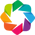

Shapes:
Y: (15000, 200, 200)
A: (26, 200, 200)
C: (26, 15000)


In [111]:
import xarray as xr
import holoviews as hv, panel as pn
import numpy as np
import dask.array as da

hv.extension("bokeh")
pn.extension()

# ===================== load saved Minian outputs =====================
dpath = "/Users/mbrosch/Documents/GitKraken_mac/minian/minian_intermediate"

Y_ds = xr.open_zarr(f"{dpath}/Y_fm_chk.zarr")   # Dataset with key 'Y_fm_chk'
A_ds = xr.open_zarr(f"{dpath}/A.zarr")          # Dataset with key 'A'
C_ds = xr.open_zarr(f"{dpath}/C.zarr")          # Dataset with key 'C'
V_ds = xr.open_zarr(f"{dpath}/varr.zarr")   # the raw movie you saved



# unwrap variables
##Y = Y_ds["Y_fm_chk"].astype("float32")   # (frame, height, width) motion corrected, filtered video
Y = V_ds["varr"].astype("float32")          # (frame, height, width)
A = A_ds["A"]                            # (height, width, unit_id)
C = C_ds["C"]                            # (unit_id, frame)

print("Shapes:")
print("Y:", tuple(Y.shape))
print("A:", tuple(A.shape))
print("C:", tuple(C.shape))

In [112]:
import numpy as np
import xarray as xr
import cv2

def make_bg_suppressed(
    Y: xr.DataArray,
    spatial_sigma_px: float = 6.0,   # ~cell/background size in px
    temporal_q: float = 0.05,        # robust per-pixel baseline (5th percentile)
    do_spatial_hp: bool = True,
    do_temporal_baseline: bool = True,
    clip_min: float = 0.0,
) -> xr.DataArray:
    """
    Background-suppress the RAW movie (varr):
      1) optional spatial high-pass per frame: frame - GaussianBlur(frame, sigma)
      2) optional temporal baseline subtraction per pixel: subtract q-quantile along 'frame'
      3) optional clamp to clip_min (e.g., 0)
    """
    Z = Y.astype("float32")

    # --- (1) spatial high-pass ---
    if do_spatial_hp and spatial_sigma_px and spatial_sigma_px > 0:
        def _hp_one(img2d: np.ndarray) -> np.ndarray:
            blurred = cv2.GaussianBlur(
                img2d, ksize=(0, 0), sigmaX=float(spatial_sigma_px),
                borderType=cv2.BORDER_REPLICATE
            )
            return img2d - blurred

        Z = xr.apply_ufunc(
            _hp_one,
            Z,
            input_core_dims=[["height", "width"]],
            output_core_dims=[["height", "width"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[np.float32],
        )

    # --- (2) temporal baseline ---
    if do_temporal_baseline:
        Zq = Z.chunk({"frame": -1})
        base = Zq.quantile(temporal_q, dim="frame")   # (height, width)
        Z = Z - base

    # --- (3) clamp ---
    if clip_min is not None:
        Z = Z.clip(min=clip_min)

    return Z.rename("varr_bg")


# ---- Build the background-suppressed movie from your RAW varr ----
Y_bg = make_bg_suppressed(
    V_ds["varr"],          # raw movie
    spatial_sigma_px=4,    # try 4–10
    temporal_q=0.05,       # 5th percentile baseline
    do_spatial_hp=True,
    do_temporal_baseline=True,
    clip_min=0.0,
)

print("Y_bg:", tuple(Y_bg.shape), "| chunks:", getattr(Y_bg.data, "chunks", "numpy"))

# Replace Y with this for plotting / overlays
Y = Y_bg

Y_bg: (15000, 200, 200) | chunks: ((750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750), (200,), (200,))


In [61]:
curation_df = pd.read_csv("curation_results.csv")
kept_units = set(curation_df.loc[curation_df["keep"] == 1, "unit_id"].values)

# --- filter A and C by kept units ---
A_kept = A.sel(unit_id=list(kept_units))
C_kept = C.sel(unit_id=list(kept_units))

# --- centroids only for kept units ---
Aw  = A_kept.clip(min=0)
den = Aw.sum(["height","width"]).clip(min=1e-12)
cy  = (Aw * ygrid).sum(["height","width"]) / den
cx  = (Aw * xgrid).sum(["height","width"]) / den

# --- circle sizes from activity (only kept) ---
frame_ix = xr.DataArray(np.arange(T), dims=["frame"])
Cu = C_kept.transpose("unit_id", "frame").assign_coords(frame_ix=("frame", frame_ix))
lo = Cu.quantile(0.05, dim="frame")
hi = Cu.quantile(0.95, dim="frame")
Cz = ((Cu - lo) / (hi - lo + 1e-12)).clip(0, 1)

cent_df = xr.Dataset({"x": cx, "y": cy}).to_dataframe().reset_index()
Cdf = Cz.to_dataframe("act").reset_index()[["unit_id", "frame_ix", "act"]]
DF = Cdf.merge(cent_df, on="unit_id", how="inner").dropna(subset=["x", "y", "act"])

In [102]:
# === Activity circles -> video export (20 FPS, MP4 preferred) ===
import numpy as np
import xarray as xr
import dask.array as da
from dask import config as dask_config
from tqdm.auto import tqdm
import cv2

# ----------------- CONFIG -----------------
N_OUT            = 500        # export first N frames
FPS              = 2
BATCH            = 100         # frames pulled from dask in chunks
PCT_MIN, PCT_MAX = 1, 99       # global display limits (viridis)
RADIUS_SCALE     = 0.18       # <-- smaller circles (tweak up/down)
CIRCLE_ALPHA     = 0.05
OUTLINE_THICK    = 1
UPS              = 2           # 1x output; set 2 for supersampling (smoother circles)
OUT_PATH_MP4     = "./activity_overlay_firstN_20fps.mp4"
OUT_PATH_AVI     = "./activity_overlay_firstN_20fps.avi"
SCALE_FACTOR     = 4           # final 4× enlargement for smoother viewing
# ------------------------------------------

# --- pick the movie dataarray (Y can be a Dataset or DataArray) ---
if isinstance(Y, xr.Dataset):
    for cand in ("varr","Y_fm_chk", "after_mc", "raw", "data_var"):
        if cand in Y.data_vars:
            Y = Y[cand]
            break
    else:
        raise ValueError("Couldn't find a movie variable in Y (looked for Y_fm_chk/after_mc/raw/data_var)")
elif not isinstance(Y, xr.DataArray):
    raise TypeError("Y must be an xarray.DataArray or Dataset")

# --- make sure A matches image plane (height/width) ---
A_ = A
for dim in ("height", "width"):
    if dim in Y.coords and dim in A_.coords and A_.sizes[dim] != Y.sizes[dim]:
        A_ = A_.reindex({dim: Y.coords[dim]})

H, W, T = int(Y.sizes["height"]), int(Y.sizes["width"]), int(Y.sizes["frame"])
N_OUT = min(N_OUT, T)

# --- robust global contrast from a sample ---
sample = min(5000, T)
flat = Y.isel(frame=slice(0, sample)).data.ravel()
vmin, vmax = [float(x) for x in da.percentile(flat, [PCT_MIN, PCT_MAX]).compute()]
rng = float(max(1e-6, vmax - vmin))

# --- centroids from A ---
h = xr.DataArray(np.arange(H), dims=["height"], coords={"height": A_.coords["height"]})
w = xr.DataArray(np.arange(W), dims=["width"],  coords={"width":  A_.coords["width"]})
ygrid, xgrid = xr.broadcast(h, w)
Aw  = A_.clip(min=0)
den = Aw.sum(["height","width"]).clip(min=1e-12)
cy  = (Aw * ygrid).sum(["height","width"]) / den
cx  = (Aw * xgrid).sum(["height","width"]) / den

# --- circle sizes from normalized activity (5–95%) ---
frame_ix = xr.DataArray(np.arange(T), dims=["frame"])
Cu = C.transpose("unit_id", "frame").assign_coords(frame_ix=("frame", frame_ix))
lo = Cu.quantile(0.05, dim="frame")
hi = Cu.quantile(0.95, dim="frame")
Cz = ((Cu - lo) / (hi - lo + 1e-12)).clip(0, 1)

cent_df = xr.Dataset({"x": cx, "y": cy}).to_dataframe().reset_index()
Cdf = Cz.to_dataframe("act").reset_index()[["unit_id", "frame_ix", "act"]]
DF = Cdf.merge(cent_df, on="unit_id", how="inner").dropna(subset=["x", "y", "act"])

BASE, SCALE = 8.0, 32.0
DF["size"] = BASE + SCALE * DF["act"]
by_frame = {int(f): g[["x", "y", "size"]].values for f, g in DF.groupby("frame_ix", sort=True)}

# --- helpers ---
def size_to_radius(sz, scale=RADIUS_SCALE):
    # HoloViews-like "size" -> pixel radius
    return max(1, int(round(sz * scale)))

# output sizes
out_w, out_h = int(W * UPS), int(H * UPS)
upW, upH = int(W * SCALE_FACTOR), int(H * SCALE_FACTOR)

# --- create writer (prefer MP4, fallback to MJPG/AVI) ---
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_path = OUT_PATH_MP4
writer = cv2.VideoWriter(out_path, fourcc, FPS, (upW, upH))

if not writer.isOpened():
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    out_path = OUT_PATH_AVI
    writer = cv2.VideoWriter(out_path, fourcc, FPS, (upW, upH))

if not writer.isOpened():
    raise RuntimeError("Could not open any VideoWriter (mp4v or MJPG). Check your OpenCV build.")

# dask -> numpy pulls
dask_config.set(scheduler="threads")

# --- export with progress bar ---
with tqdm(total=N_OUT, desc=f"Writing video ({FPS} FPS)") as pbar:
    for s0 in range(0, N_OUT, BATCH):
        s1 = min(N_OUT, s0 + BATCH)

        # load a slab and normalize to uint8
        if BG_MODE == "raw":
            slab = Y.isel(frame=slice(s0, s1)).data.astype("float32").compute()
        elif BG_MODE in ("mean","max"):
        # one static image repeated (mean or max projection)
        img = (Y.mean("frame") if BG_MODE=="mean" else Y.max("frame")).values.astype("float32")
        slab = np.repeat(img[None, ...], s1-s0, axis=0)
        norm = np.clip((slab - vmin) / rng, 0.0, 1.0)
        u8   = (norm * 255.0).astype(np.uint8)

        for i in range(u8.shape[0]):
            f = s0 + i
            # grayscale -> viridis BGR
            bgr = cv2.applyColorMap(u8[i], cv2.COLORMAP_VIRIDIS)

            # optional supersample
            if UPS != 1:
                bgr = cv2.resize(bgr, (out_w, out_h), interpolation=cv2.INTER_LINEAR)

            # circles
            pts = by_frame.get(int(f))
            if pts is not None and len(pts):
                overlay = bgr.copy()
                for x, y, sz in pts:
                    cx = int(np.clip(round(x * UPS), 0, out_w - 1))
                    cy = int(np.clip(round(y * UPS), 0, out_h - 1))
                    r  = size_to_radius(sz) * UPS
                    cv2.circle(overlay, (cx, cy), r, (255, 255, 0), thickness=-1, lineType=cv2.LINE_AA)
                cv2.addWeighted(overlay, CIRCLE_ALPHA, bgr, 1.0 - CIRCLE_ALPHA, 0, bgr)
                for x, y, sz in pts:
                    cx = int(np.clip(round(x * UPS), 0, out_w - 1))
                    cy = int(np.clip(round(y * UPS), 0, out_h - 1))
                    r  = size_to_radius(sz) * UPS
                    cv2.circle(bgr, (cx, cy), r, (0, 0, 0), thickness=OUTLINE_THICK, lineType=cv2.LINE_AA)

            # final 4× enlargement for smoother viewing
            frame_up = cv2.resize(bgr, (upW, upH), interpolation=cv2.INTER_NEAREST)
            writer.write(frame_up)
            pbar.update(1)

writer.release()
print(f"Wrote: {out_path}")

IndentationError: expected an indented block (83403992.py, line 108)

In [109]:
# === Activity circles -> video export (kept units only; grayscale bg; no centroid X) ===
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
from dask import config as dask_config
from tqdm.auto import tqdm
import cv2

# ----------------- CONFIG -----------------
N_OUT            = 5000          # export first N frames
FPS              = 5
BATCH            = 100          # frames pulled from dask in chunks
PCT_MIN, PCT_MAX = 1, 99        # global display limits for grayscale
UPS              = 2            # 1x output; set 2 for supersampling
SCALE_FACTOR     = 4            # final 4× enlargement for smoother viewing

# activity circles
BASE, SCALE      = 8.0, 32.0    # size = BASE + SCALE * normalized_activity
RADIUS_SCALE     = 0.18         # size -> pixel radius
CIRCLE_ALPHA     = 0.20         # fill opacity for circles (0..1)
CIRCLE_FILL_BGR  = (200, 230, 230)
CIRCLE_EDGE_BGR  = (0, 0, 0)
CIRCLE_EDGE_THK  = 1

# footprint outlines
FOOT_THR         = 0.40         # thr * max(A) for mask
FOOT_COLOR       = (0, 255, 255)
FOOT_THICK       = 1
MIN_AREA         = 6            # ignore tiny specks (pixels)

# background mode: "raw" (per-frame), "mean", or "max"
BG_MODE          = "raw"

OUT_PATH_MP4     = "./activity_overlay_kept_20fps.mp4"
OUT_PATH_AVI     = "./activity_overlay_kept_20fps.avi"
# ------------------------------------------

# --- pick the movie dataarray (Y can be a Dataset or DataArray) ---
if isinstance(Y, xr.Dataset):
    for cand in ("Y_fm_chk", "after_mc", "raw", "data_var"):
        if cand in Y.data_vars:
            Y = Y[cand]
            break
    else:
        raise ValueError("Couldn't find a movie variable in Y (looked for Y_fm_chk/after_mc/raw/data_var)")
elif not isinstance(Y, xr.DataArray):
    raise TypeError("Y must be an xarray.DataArray or Dataset")

# --- load curation -> kept unit ids (fallback: keep all if file missing) ---
try:
    curation_df = pd.read_csv("curation_results.csv")
    kept_units  = set(map(int, curation_df.loc[curation_df["keep"] == 1, "unit_id"].values))
except Exception:
    kept_units  = set(map(int, A.unit_id.values))  # fallback to all

# (safety) intersect with what actually exists in A/C
present = set(map(int, A.unit_id.values)) & set(map(int, C.unit_id.values))
kept_units = sorted(kept_units & present)
if not kept_units:
    raise ValueError("No kept units found after intersecting with A/C unit_id.")

# --- ensure A matches image plane (height/width) and filter to kept units ---
A_ = A
for dim in ("height", "width"):
    if dim in Y.coords and dim in A_.coords and A_.sizes[dim] != Y.sizes[dim]:
        A_ = A_.reindex({dim: Y.coords[dim]})
A_ = A_.sel(unit_id=kept_units)

# --- filter C to the same kept units ---
C_ = C.sel(unit_id=kept_units)

H, W, T = int(Y.sizes["height"]), int(Y.sizes["width"]), int(Y.sizes["frame"])
N_OUT = min(N_OUT, T)

# --- robust global contrast from a sample (for grayscale normalization) ---
sample = min(5000, T)
flat = Y.isel(frame=slice(0, sample)).data.ravel()
vmin, vmax = [float(x) for x in da.percentile(flat, [PCT_MIN, PCT_MAX]).compute()]
rng = float(max(1e-6, vmax - vmin))

# --- precompute static background if requested ---
if BG_MODE in ("mean", "max"):
    bg_img = (Y.mean("frame") if BG_MODE == "mean" else Y.max("frame")).values.astype("float32")

# --- centroids from A_ (needed to place circles) ---
h = xr.DataArray(np.arange(H), dims=["height"], coords={"height": A_.coords["height"]})
w = xr.DataArray(np.arange(W), dims=["width"],  coords={"width":  A_.coords["width"]})
ygrid, xgrid = xr.broadcast(h, w)

Aw  = A_.clip(min=0)
den = Aw.sum(["height","width"]).clip(min=1e-12)
cy  = (Aw * ygrid).sum(["height","width"]) / den
cx  = (Aw * xgrid).sum(["height","width"]) / den
cent_df = xr.Dataset({"x": cx, "y": cy}).to_dataframe().reset_index()

# --- activity normalization (5–95%) and by-frame table ---
frame_ix = xr.DataArray(np.arange(T), dims=["frame"])
Cu = C_.transpose("unit_id", "frame").assign_coords(frame_ix=("frame", frame_ix))
lo = Cu.quantile(0.05, dim="frame")
hi = Cu.quantile(0.95, dim="frame")
Cz = ((Cu - lo) / (hi - lo + 1e-12)).clip(0, 1)

Cdf = Cz.to_dataframe("act").reset_index()[["unit_id", "frame_ix", "act"]]
DF  = Cdf.merge(cent_df, on="unit_id", how="inner").dropna(subset=["x", "y", "act"])
DF  = DF.sort_values(["frame_ix", "unit_id"])
DF["size"] = BASE + SCALE * DF["act"]
by_frame = {int(f): g[["x", "y", "size"]].values for f, g in DF.groupby("frame_ix", sort=True)}

# --- precompute footprint contours (native scale) ---
contours_base = []
for uid in A_.unit_id.values:
    m = A_.sel(unit_id=int(uid)).values.astype("float32")
    thr  = float(m.max()) * float(FOOT_THR)
    mask = (m > thr).astype("uint8") * 255
    if mask.any():
        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in cnts:
            if cv2.contourArea(c) >= MIN_AREA:
                contours_base.append(c.astype(np.float32))   # keep float for later scaling

# --- helpers ---
def size_to_radius(sz, scale=RADIUS_SCALE):
    return max(1, int(round(sz * scale)))

out_w, out_h = int(W * UPS), int(H * UPS)
upW, upH     = int(W * SCALE_FACTOR), int(H * SCALE_FACTOR)

# --- create writer (prefer MP4, fallback to MJPG/AVI) ---
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_path = OUT_PATH_MP4
writer = cv2.VideoWriter(out_path, fourcc, FPS, (upW, upH))
if not writer.isOpened():
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    out_path = OUT_PATH_AVI
    writer = cv2.VideoWriter(out_path, fourcc, FPS, (upW, upH))
if not writer.isOpened():
    raise RuntimeError("Could not open any VideoWriter (mp4v or MJPG). Check your OpenCV build.")

# dask -> numpy pulls
dask_config.set(scheduler="threads")

# --- export with progress bar ---
with tqdm(total=N_OUT, desc=f"Writing video ({FPS} FPS)") as pbar:
    for s0 in range(0, N_OUT, BATCH):
        s1 = min(N_OUT, s0 + BATCH)

        # background slab
        if BG_MODE == "raw":
            slab = Y.isel(frame=slice(s0, s1)).data.astype("float32").compute()  # (n,H,W)
        else:  # mean / max -> repeat static bg
            slab = np.repeat(bg_img[None, ...], s1 - s0, axis=0)

        # normalize -> 8-bit grayscale
        norm = np.clip((slab - vmin) / rng, 0.0, 1.0)
        u8   = (norm * 255.0).astype(np.uint8)cv2.addWeig

        for i in range(u8.shape[0]):
            f = s0 + i

            # 1ch -> 3ch BGR (grayscale look)
            bgr = cv2.cvtColor(u8[i], cv2.COLOR_GRAY2BGR)

            # supersample the frame (UPS)
            if UPS != 1:
                bgr = cv2.resize(bgr, (out_w, out_h), interpolation=cv2.INTER_LINEAR)

            # activity circles (kept units only)
            pts = by_frame.get(int(f))
            if pts is not None and len(pts):
                overlay = bgr.copy()
                for x, y, sz in pts:
                    cx = int(np.clip(round(x * UPS), 0, out_w - 1))
                    cy = int(np.clip(round(y * UPS), 0, out_h - 1))
                    r  = size_to_radius(sz) * UPS
                    cv2.circle(overlay, (cx, cy), r, CIRCLE_FILL_BGR,
                               thickness=-1, lineType=cv2.LINE_AA)
                cv2.addWeighted(overlay, CIRCLE_ALPHA, bgr, 1.0 - CIRCLE_ALPHA, 0, bgr)
                for x, y, sz in pts:
                    cx = int(np.clip(round(x * UPS), 0, out_w - 1))
                    cy = int(np.clip(round(y * UPS), 0, out_h - 1))
                    r  = size_to_radius(sz) * UPS
                    cv2.circle(bgr, (cx, cy), r, CIRCLE_EDGE_BGR,
                               thickness=CIRCLE_EDGE_THK, lineType=cv2.LINE_AA)

            # footprint outlines (scale contours to UPS)
            if contours_base:
                contours_up = [(c * UPS).astype(np.int32) for c in contours_base]
                cv2.polylines(bgr, contours_up, isClosed=True, color=FOOT_COLOR,
                              thickness=FOOT_THICK, lineType=cv2.LINE_AA)

            # final large upscale for smoother viewing
            frame_up = cv2.resize(bgr, (upW, upH), interpolation=cv2.INTER_NEAREST)
            writer.write(frame_up)
            pbar.update(1)

writer.release()
print(f"Wrote: {out_path}")

Writing video (5 FPS):   0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [120]:
# === Activity circles -> video export (kept units only; FAST; no darkening) ===
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
from dask import config as dask_config
from tqdm.auto import tqdm
import cv2

# ----------------- CONFIG -----------------
N_OUT            = 15000          # export first N frames
FPS              = 5
BATCH            = 300          # bigger pulls -> fewer dask calls
PCT_MIN, PCT_MAX = 1, 99        # global display limits for grayscale

SCALE            = 5            # render directly at final size (integer upscale)

# activity circles
BASE, SCALE_ACT  = 8.0, 32.0    # size = BASE + SCALE_ACT * normalized_activity
RADIUS_SCALE     = 0.18         # size -> pixel radius
CIRCLE_ALPHA     = 0.05         # fill opacity for circles (0..1)
CIRCLE_FILL_BGR  = (0, 255, 0)
CIRCLE_EDGE_BGR  = (255, 0, 0)
CIRCLE_EDGE_THK  = 1

# footprint outlines (static; drawn per-frame, no blending)
FOOT_THR         = 0.40
FOOT_COLOR       = (0, 255, 255)
FOOT_THICK       = 1
MIN_AREA         = 6            # ignore tiny specks (pixels)

# background: "raw" (per-frame), "mean", or "max"
BG_MODE          = "raw"

OUT_PATH_MP4     = "./activity_overlay_kept_fast.mp4"
OUT_PATH_AVI     = "./activity_overlay_kept_fast.avi"
# ------------------------------------------

# --- pick the movie dataarray (Y can be a Dataset or DataArray) ---
if isinstance(Y, xr.Dataset):
    for cand in ("Y_fm_chk", "after_mc", "raw", "data_var"):
        if cand in Y.data_vars:
            Y = Y[cand]
            break
    else:
        raise ValueError("Couldn't find a movie variable in Y.")
elif not isinstance(Y, xr.DataArray):
    raise TypeError("Y must be an xarray.DataArray or Dataset")

# --- load curation -> kept unit ids (fallback: keep all) ---
try:
    curation_df = pd.read_csv("curation_results.csv")
    kept_units  = set(map(int, curation_df.loc[curation_df["keep"] == 1, "unit_id"].values))
except Exception:
    kept_units  = set(map(int, A.unit_id.values))

present = set(map(int, A.unit_id.values)) & set(map(int, C.unit_id.values))
kept_units = sorted(kept_units & present)
if not kept_units:
    raise ValueError("No kept units found after intersecting with A/C unit_id.")

# --- ensure A matches image plane and filter to kept units ---
A_ = A
for dim in ("height", "width"):
    if dim in Y.coords and dim in A_.coords and A_.sizes[dim] != Y.sizes[dim]:
        A_ = A_.reindex({dim: Y.coords[dim]})
A_ = A_.sel(unit_id=kept_units)
C_ = C.sel(unit_id=kept_units)

H, W, T = int(Y.sizes["height"]), int(Y.sizes["width"]), int(Y.sizes["frame"])
N_OUT = min(N_OUT, T)

# --- robust global contrast from a sample ---
sample = min(15000, T)
flat = Y.isel(frame=slice(0, sample)).data.ravel()
vmin, vmax = [float(x) for x in da.percentile(flat, [PCT_MIN, PCT_MAX]).compute()]
rng = float(max(1e-6, vmax - vmin))

# --- optional static bg ---
if BG_MODE in ("mean", "max"):
    bg_img = (Y.mean("frame") if BG_MODE == "mean" else Y.max("frame")).values.astype("float32")

# --- centroids from A_ ---
h = xr.DataArray(np.arange(H), dims=["height"], coords={"height": A_.coords["height"]})
w = xr.DataArray(np.arange(W), dims=["width"],  coords={"width":  A_.coords["width"]})
ygrid, xgrid = xr.broadcast(h, w)

Aw  = A_.clip(min=0)
den = Aw.sum(["height","width"]).clip(min=1e-12)
cy  = (Aw * ygrid).sum(["height","width"]) / den
cx  = (Aw * xgrid).sum(["height","width"]) / den
cent_df = xr.Dataset({"x": cx, "y": cy}).to_dataframe().reset_index()

# --- activity normalization (5–95%) and per-frame payload ---
frame_ix = xr.DataArray(np.arange(T), dims=["frame"])
Cu = C_.transpose("unit_id", "frame").assign_coords(frame_ix=("frame", frame_ix))
lo = Cu.quantile(0.05, dim="frame")
hi = Cu.quantile(0.95, dim="frame")
Cz = ((Cu - lo) / (hi - lo + 1e-12)).clip(0, 1)

Cdf = Cz.to_dataframe("act").reset_index()[["unit_id", "frame_ix", "act"]]
DF  = Cdf.merge(cent_df, on="unit_id", how="inner").dropna(subset=["x", "y", "act"])
DF  = DF.sort_values(["frame_ix", "unit_id"])
DF["size"] = BASE + SCALE_ACT * DF["act"]

# --- output geometry ---
out_w, out_h = int(W * SCALE), int(H * SCALE)
DF["x_out"] = np.clip(np.round(DF["x"].values * SCALE), 0, out_w - 1).astype(np.int32)
DF["y_out"] = np.clip(np.round(DF["y"].values * SCALE), 0, out_h - 1).astype(np.int32)
by_frame = {int(f): g[["x_out", "y_out", "size"]].to_numpy(dtype=np.int32)
            for f, g in DF.groupby("frame_ix", sort=True)}

# --- precompute footprint contours at output resolution (no blending) ---
contours_scaled = []
for uid in A_.unit_id.values:
    m = A_.sel(unit_id=int(uid)).values.astype("float32")
    thr  = float(m.max()) * float(FOOT_THR)
    mask = (m > thr).astype("uint8") * 255
    if not mask.any():
        continue
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in cnts:
        if cv2.contourArea(c) < MIN_AREA:
            continue
        c_up = (c.astype(np.float32) * SCALE).astype(np.int32)
        contours_scaled.append(c_up)

def size_to_radius(sz):
    return max(1, int(round(float(sz) * RADIUS_SCALE * SCALE)))

# --- writer ---
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_path = OUT_PATH_MP4
writer = cv2.VideoWriter(out_path, fourcc, FPS, (out_w, out_h))
if not writer.isOpened():
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    out_path = OUT_PATH_AVI
    writer = cv2.VideoWriter(out_path, fourcc, FPS, (out_w, out_h))
if not writer.isOpened():
    raise RuntimeError("Could not open VideoWriter.")

# dask -> numpy pulls
dask_config.set(scheduler="threads")

# --- export ---
with tqdm(total=N_OUT, desc=f"Writing video ({FPS} FPS, scale={SCALE}x)") as pbar:
    for s0 in range(0, N_OUT, BATCH):
        s1 = min(N_OUT, s0 + BATCH)

        if BG_MODE == "raw":
            slab = Y.isel(frame=slice(s0, s1)).data.astype("float32").compute()  # (n,H,W)
        else:
            slab = np.repeat(bg_img[None, ...], s1 - s0, axis=0)

        norm = np.clip((slab - vmin) / rng, 0.0, 1.0)
        u8   = (norm * 255.0).astype(np.uint8)

        for i in range(u8.shape[0]):
            f = s0 + i
            frame = cv2.cvtColor(u8[i], cv2.COLOR_GRAY2BGR)
            if SCALE != 1:
                frame = cv2.resize(frame, (out_w, out_h), interpolation=cv2.INTER_LINEAR)

            # activity circles
            pts = by_frame.get(int(f))
            if pts is not None and len(pts):
                overlay = frame.copy()
                for cx, cy, sz in pts:
                    r = size_to_radius(sz)
                    cv2.circle(overlay, (int(cx), int(cy)), r, CIRCLE_FILL_BGR, -1, cv2.LINE_AA)
                cv2.addWeighted(overlay, CIRCLE_ALPHA, frame, 1.0 - CIRCLE_ALPHA, 0, frame)
                for cx, cy, sz in pts:
                    r = size_to_radius(sz)
                    cv2.circle(frame, (int(cx), int(cy)), r, CIRCLE_EDGE_BGR, CIRCLE_EDGE_THK, cv2.LINE_AA)

            # footprint outlines (draw directly; no darkening)
            for c_up in contours_scaled:
                cv2.polylines(frame, [c_up], True, FOOT_COLOR, FOOT_THICK, cv2.LINE_AA)

            writer.write(frame)
            pbar.update(1)

writer.release()
print(f"Wrote: {out_path}")

Writing video (5 FPS, scale=5x):   0%|          | 0/15000 [00:00<?, ?it/s]

Wrote: ./activity_overlay_kept_fast.mp4


## close cluster

In [ ]:
client.close()
cluster.close()